In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

#Sonnenaufgang/Sonnenuntergang laden
df_ = pd.read_csv("Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True, usecols=[0,2])
df_ = df_.join(pd.read_csv("Datenbeschaffung/stuttgart.csv", index_col=0, parse_dates=True, usecols=[0, 8, 9]))

#Tagesstunden berechnen
df["tagesstunden"] = round((pd.to_timedelta(
    pd.to_datetime(df_["sonnenuntergang"]).dt.strftime("%H:%M:%S")).dt.total_seconds() - 
    pd.to_timedelta(pd.to_datetime(df_["sonnenaufgang"]).dt.strftime("%H:%M:%S")).dt.total_seconds()) / 3600, 1)

#Temporär für Analysen verwendete Spalten berechnen
df["tagesstunden_gerundet"] = round(df["tagesstunden"],0)

#Aufteilung in zwei DataFrames für weitere Analysen
df_arbeitstag = df[df["arbeitstag"] == 1]
df_arbeitsfreiertag = df[df["arbeitstag"] == 0]

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag  arbeitstag  temperatur  tagesstunden  tagesstunden_gerundet
datum                                                                                                   
2015-01-01     126197    Januar  Donnerstag           0        -2.5           8.4                    8.0
2015-01-02     147085    Januar     Freitag           1        -0.0           8.4                    8.0
2015-01-03     141426    Januar     Samstag           0         1.2           8.4                    8.0
2015-01-04     132446    Januar     Sonntag           0        -0.2           8.4                    8.0
2015-01-05     152611    Januar      Montag           1        -0.5           8.4                    8.0
...               ...       ...         ...         ...         ...           ...                    ...
2021-12-27     153489  Dezember      Montag           1         5.7           8.3                    8.0
2021-12-28     155182  Dezember    Dienstag           1

# <font size="7">Datenanalyse</font>

<font size="5">Aus dem Sonnenaufgang und Sonnenuntergang wird jeweils die Anzahl an Tagesstunden berechnet. Die kürzesten Tage liegen mit etwas über acht Stunden stets Ende Dezember, im Sommer erreichen die längsten Tage etwa 16,5 Stunden. Aufgrund meteorologischer Begebenheiten ergibt sich eine fast perfekte jährliche Saisonalität.</font>

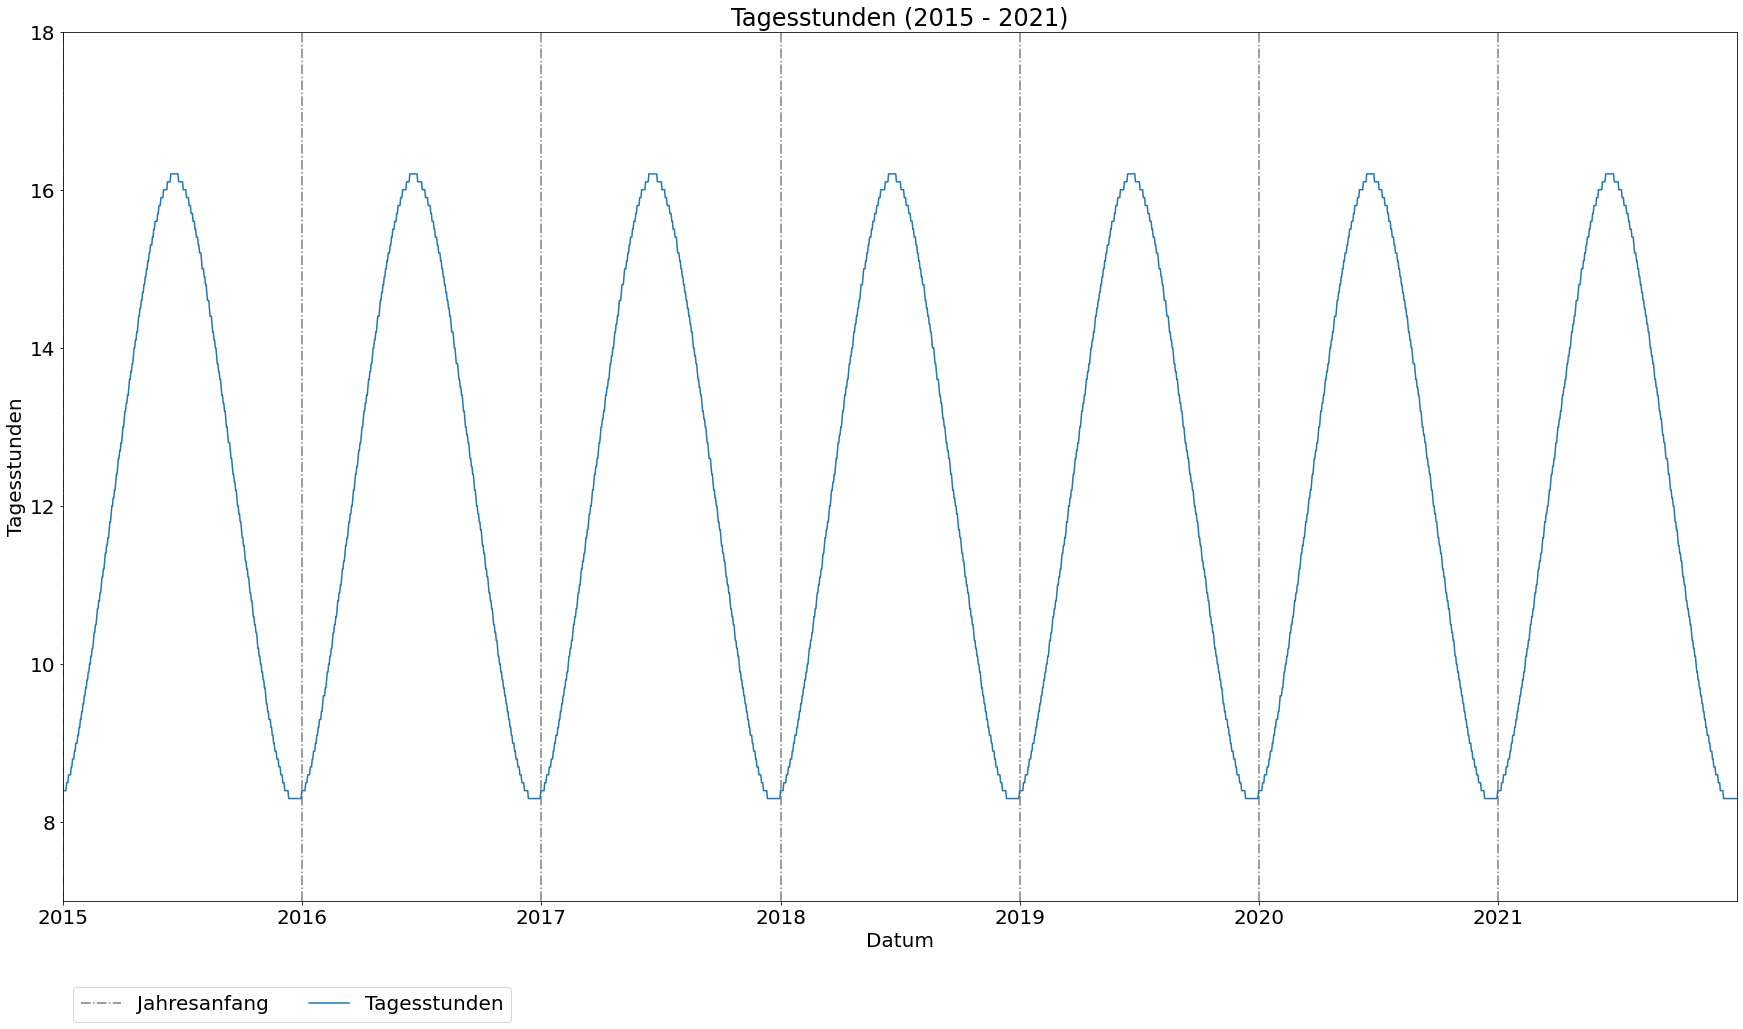

In [3]:
functions.draw_years(df)

#Tagesstunden plotten
plt.plot(df["tagesstunden"], label="Tagesstunden");
#plt.plot(df["tagesstunden"].rolling(window=14).mean(), color="red", label="Gleitender Durchschnitt über 14 Tage")

#Achsen und Layout
plt.title("Tagesstunden (2015 - 2021)")
plt.ylabel("Tagesstunden")
plt.ylim(7, 18)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

plt.show()

<font size="5">Diese Saisonalität spiegelt sich auch in den Boxplots wider.</font>

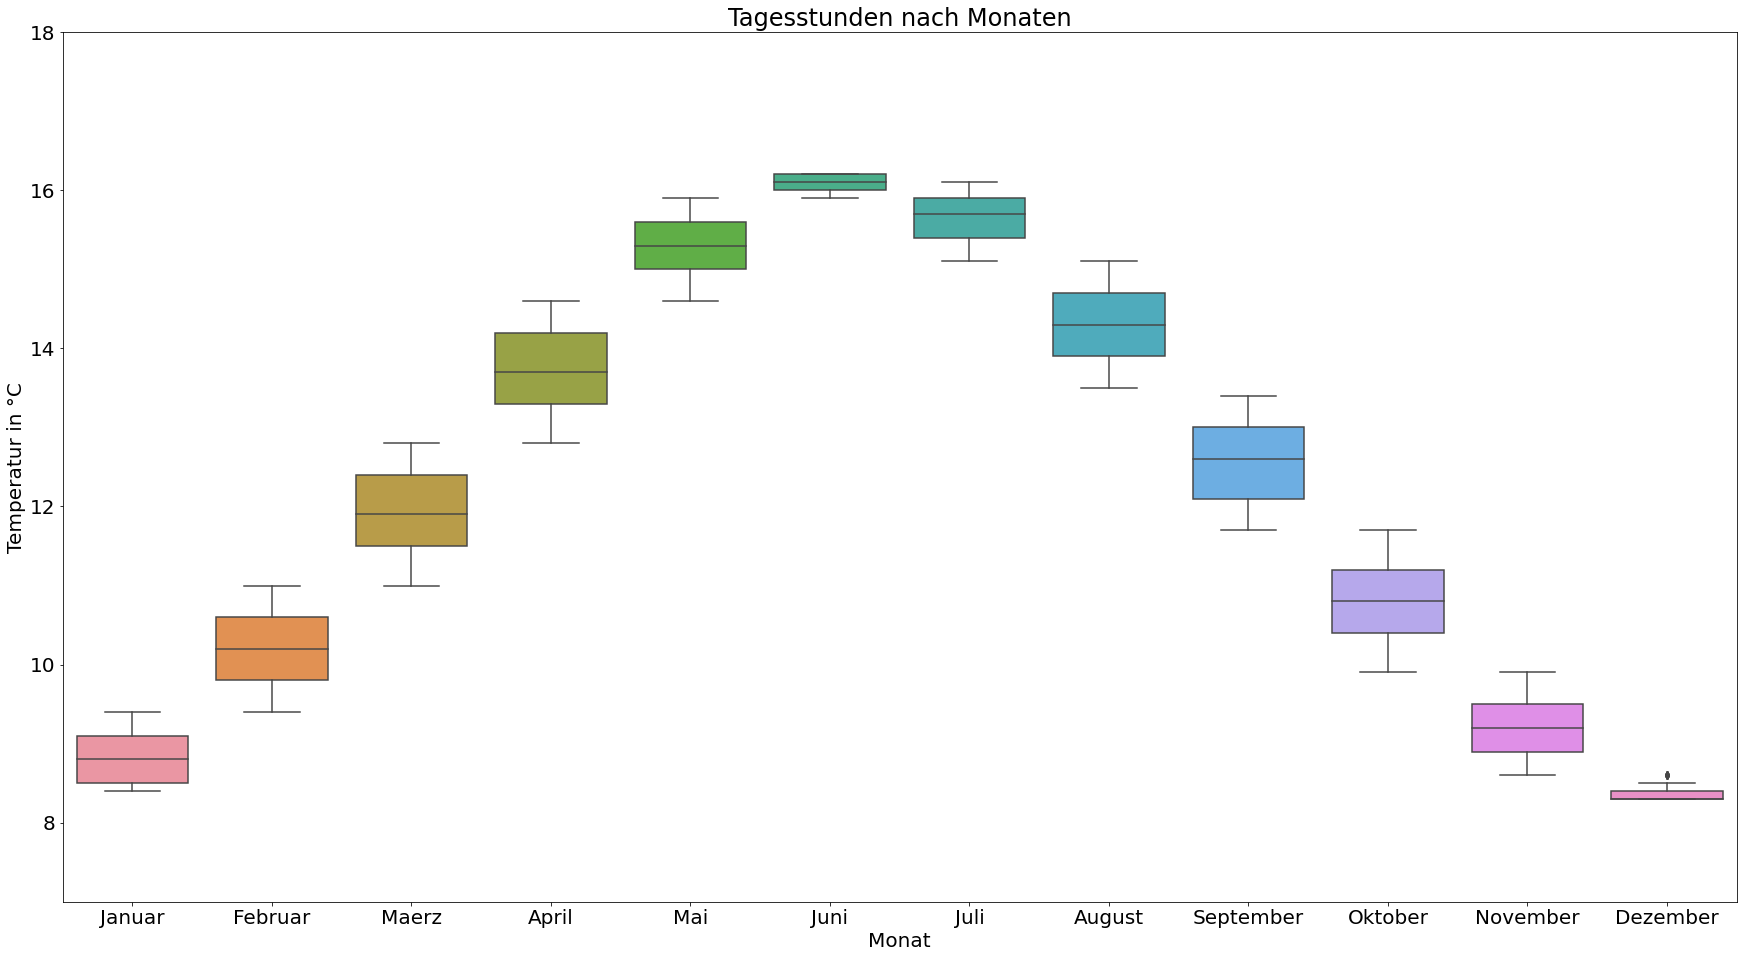

In [4]:
#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="tagesstunden")

#Achsen und Layout
plt.title("Tagesstunden nach Monaten")
plt.ylabel("Temperatur in °C")
plt.ylim(7, 18)
plt.xlabel("Monat")

plt.show()

<font size="5">Das Histogramm zeigt, dass die Verteilung hin zu den Extrema um acht und 16 Stunden hin verzerrt ist.</font>

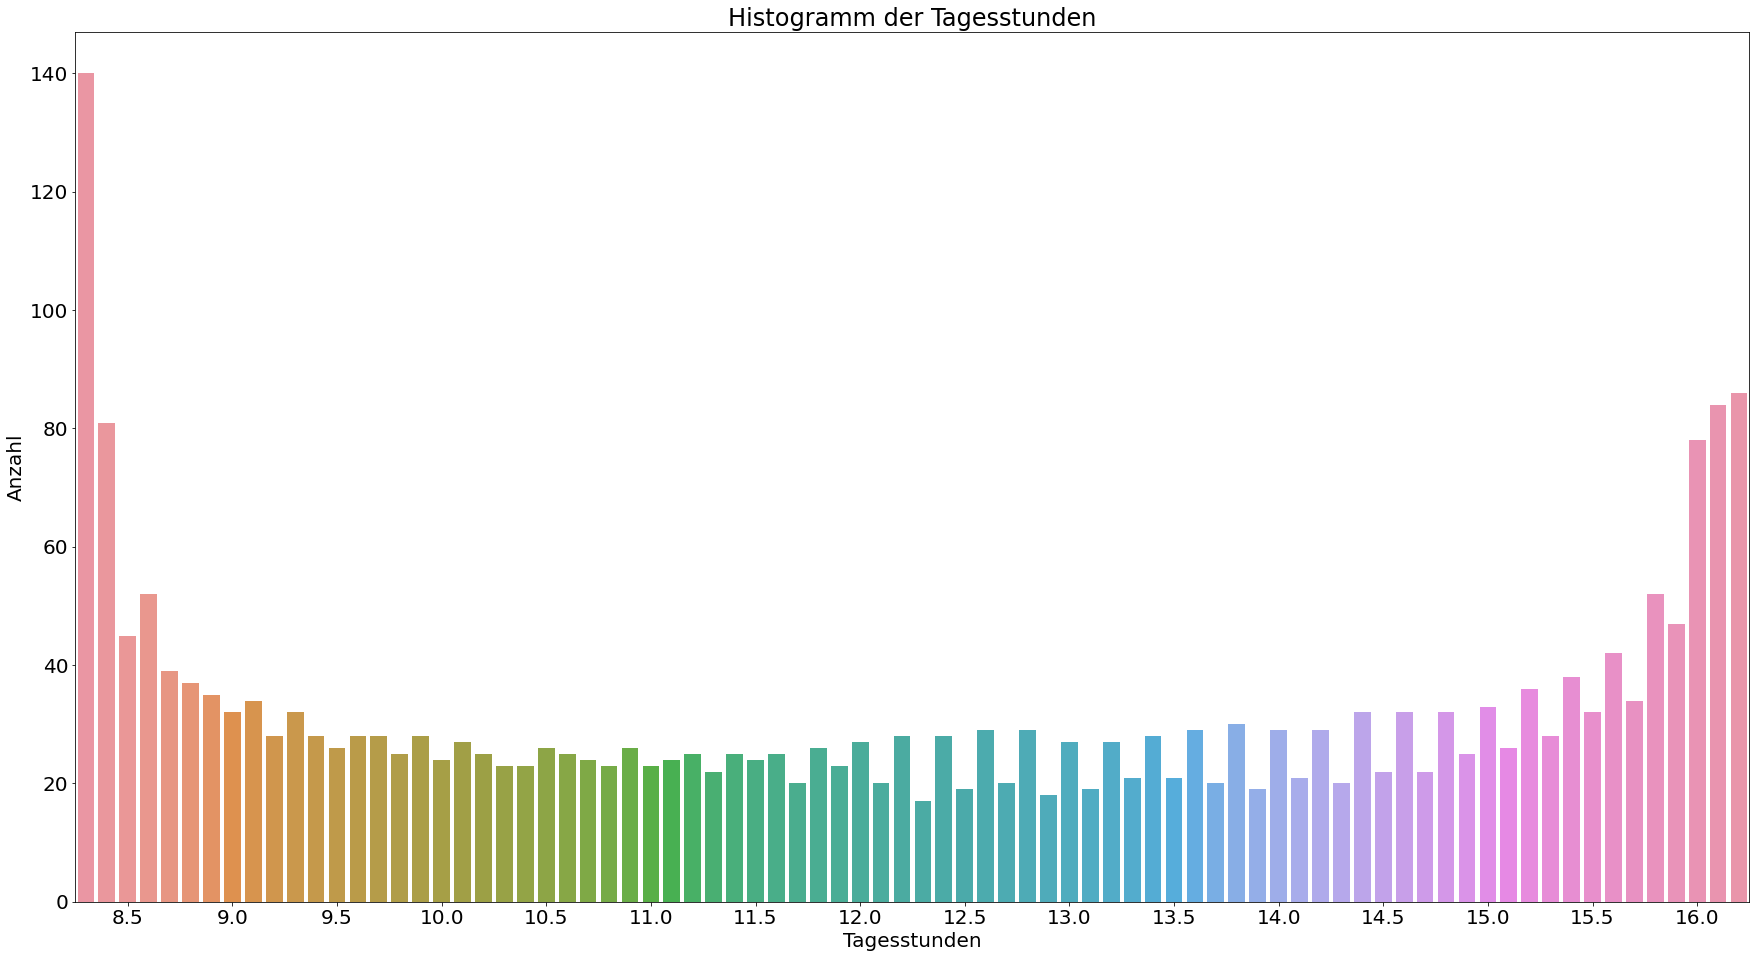

In [5]:
#Histogramm erstellen
sns.countplot(df["tagesstunden"])

#Achsen und Layout
plt.title("Histogramm der Tagesstunden")
plt.ylabel("Anzahl")
plt.xlabel("Tagesstunden")
plt.xticks(np.arange(2, 80, 5))

plt.show()

# <font size="7">Korrelationsanalyse</font>

## <font size="6">Liniendiagramm (Verlauf)</font><a class="anchor" id="2-03b-verlauf"></a>

<font size="5">Ähnlich wie bei der Temperatur läuft die Anzahl der Tagesstunden grundsätzlich auch dem Stromverbrauch entgegen. Allerdings scheint der Zusammenhang nicht so stark ausgeprägt zu sein wie bei der Temperatur, auch der Anstieg des Stromverbrauchs in der Mitte des Jahres lässt sich hierdurch nicht erklären. Es muss also geprüft werden, ob sich ein tatsächlicher Zusammenhang zwischen den Tagesstunden und dem Stromverbrauch finden lässt oder ob es sich um eine Scheinkorrelation mit dem Stromverbrauch handelt, welche durch die Jahreszeiten beziehugnsweise die damit verbundenen Änderungen der Temperatur bedingt ist.</font>

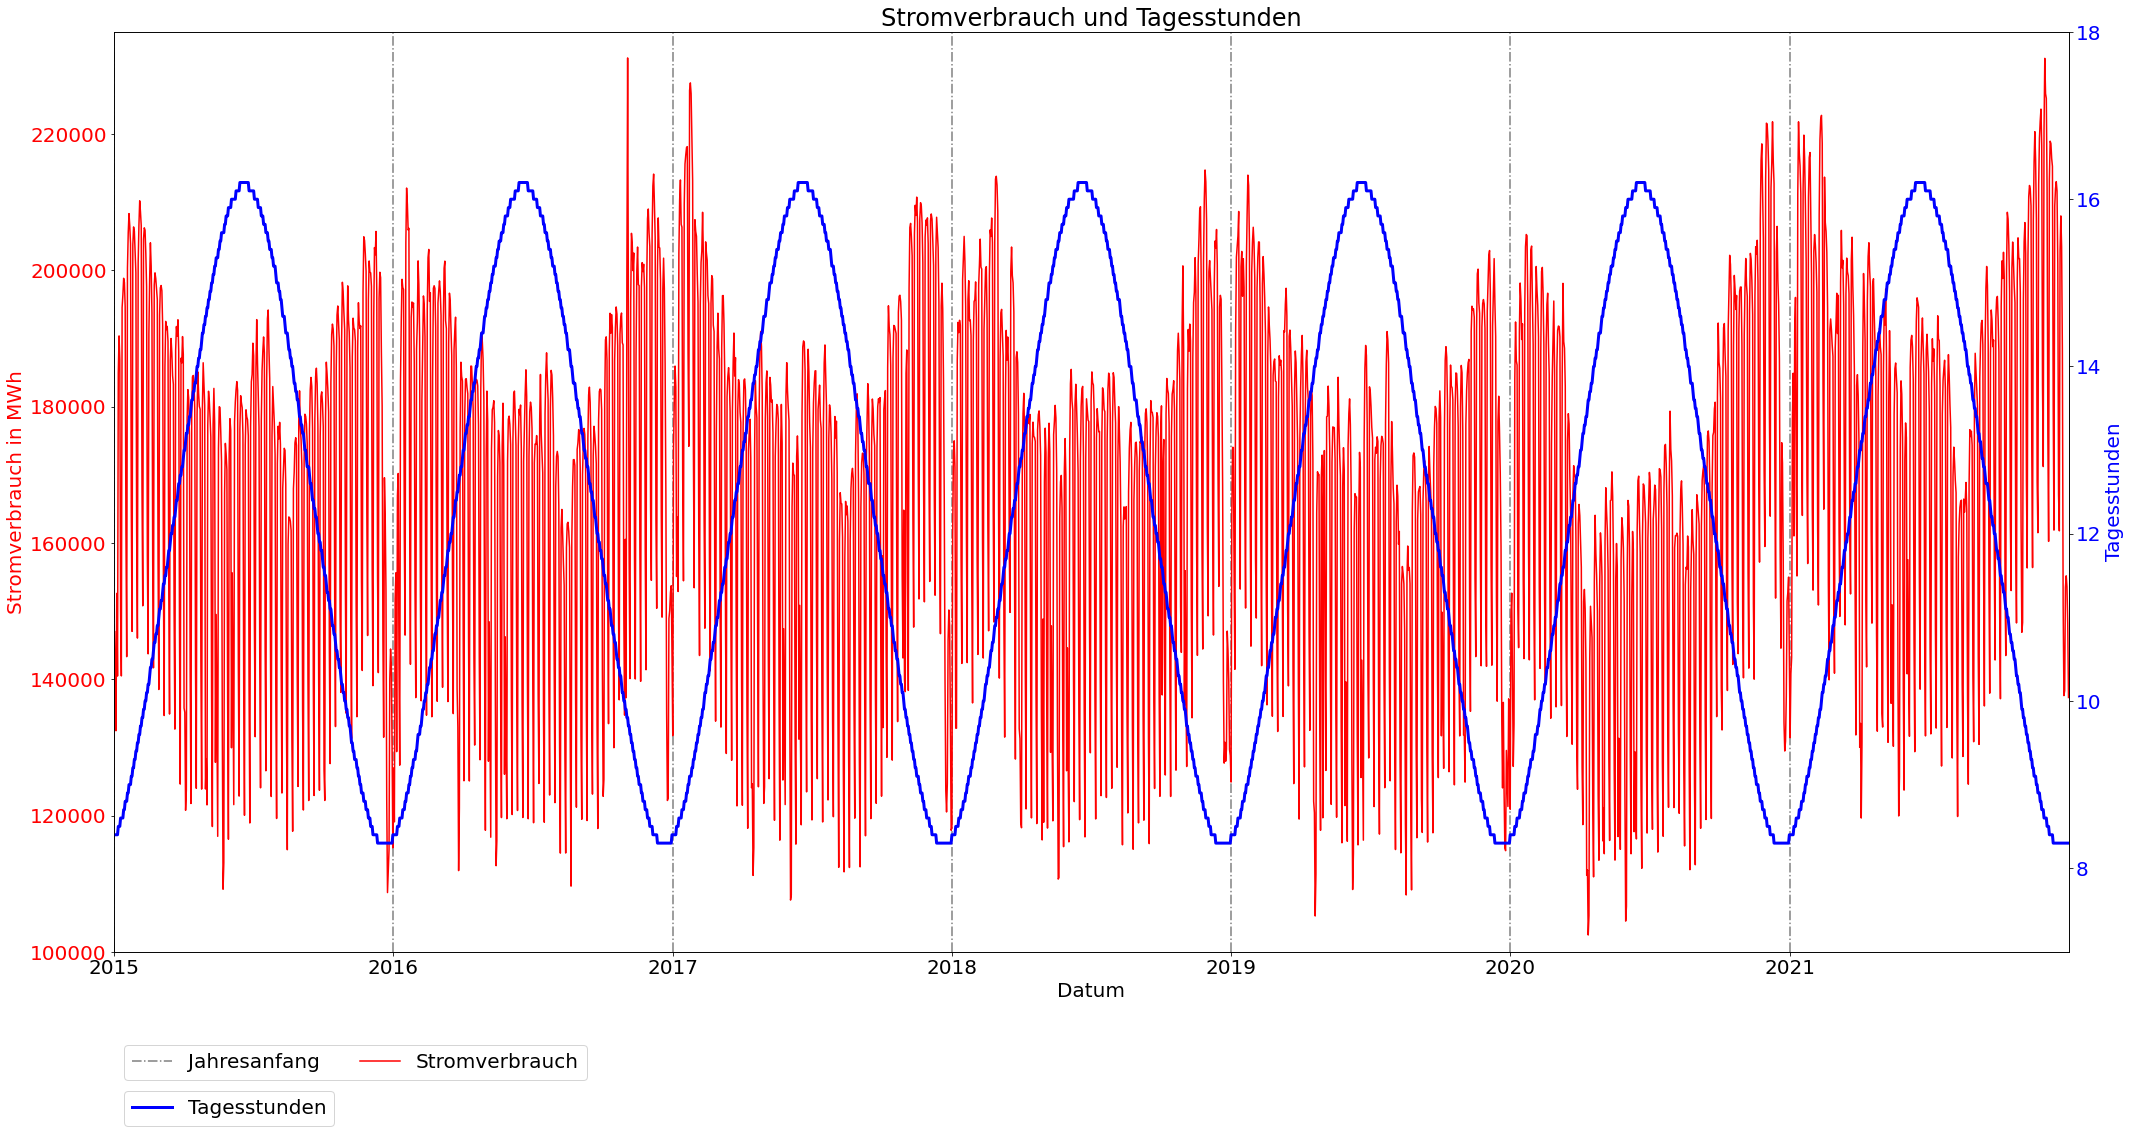

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.315
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.333
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.24





In [6]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Stromverbrauch und Tagesstunden")

#Verbrauch plotten
ax1.plot(df["verbrauch"], color="red", label="Stromverbrauch")
#Achsen und Layout
ax1.set_ylabel("Stromverbrauch in MWh", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(100000,235000)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Tagesstunden plotten
ax2.plot(df["tagesstunden"], color="blue", linewidth=3, label="Tagesstunden")
#Achsen und Layout
ax2.set_ylabel("Tagesstunden", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(7, 18)
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["tagesstunden"], df["verbrauch"])
print("\n\n")

<a class="anchor" id="2-03b-verlaufdurchschnitte"></a>



 Gleitender Durchschnitt über 3  Tage----------------------------------------------------------------------------------------------------------------------------------------------




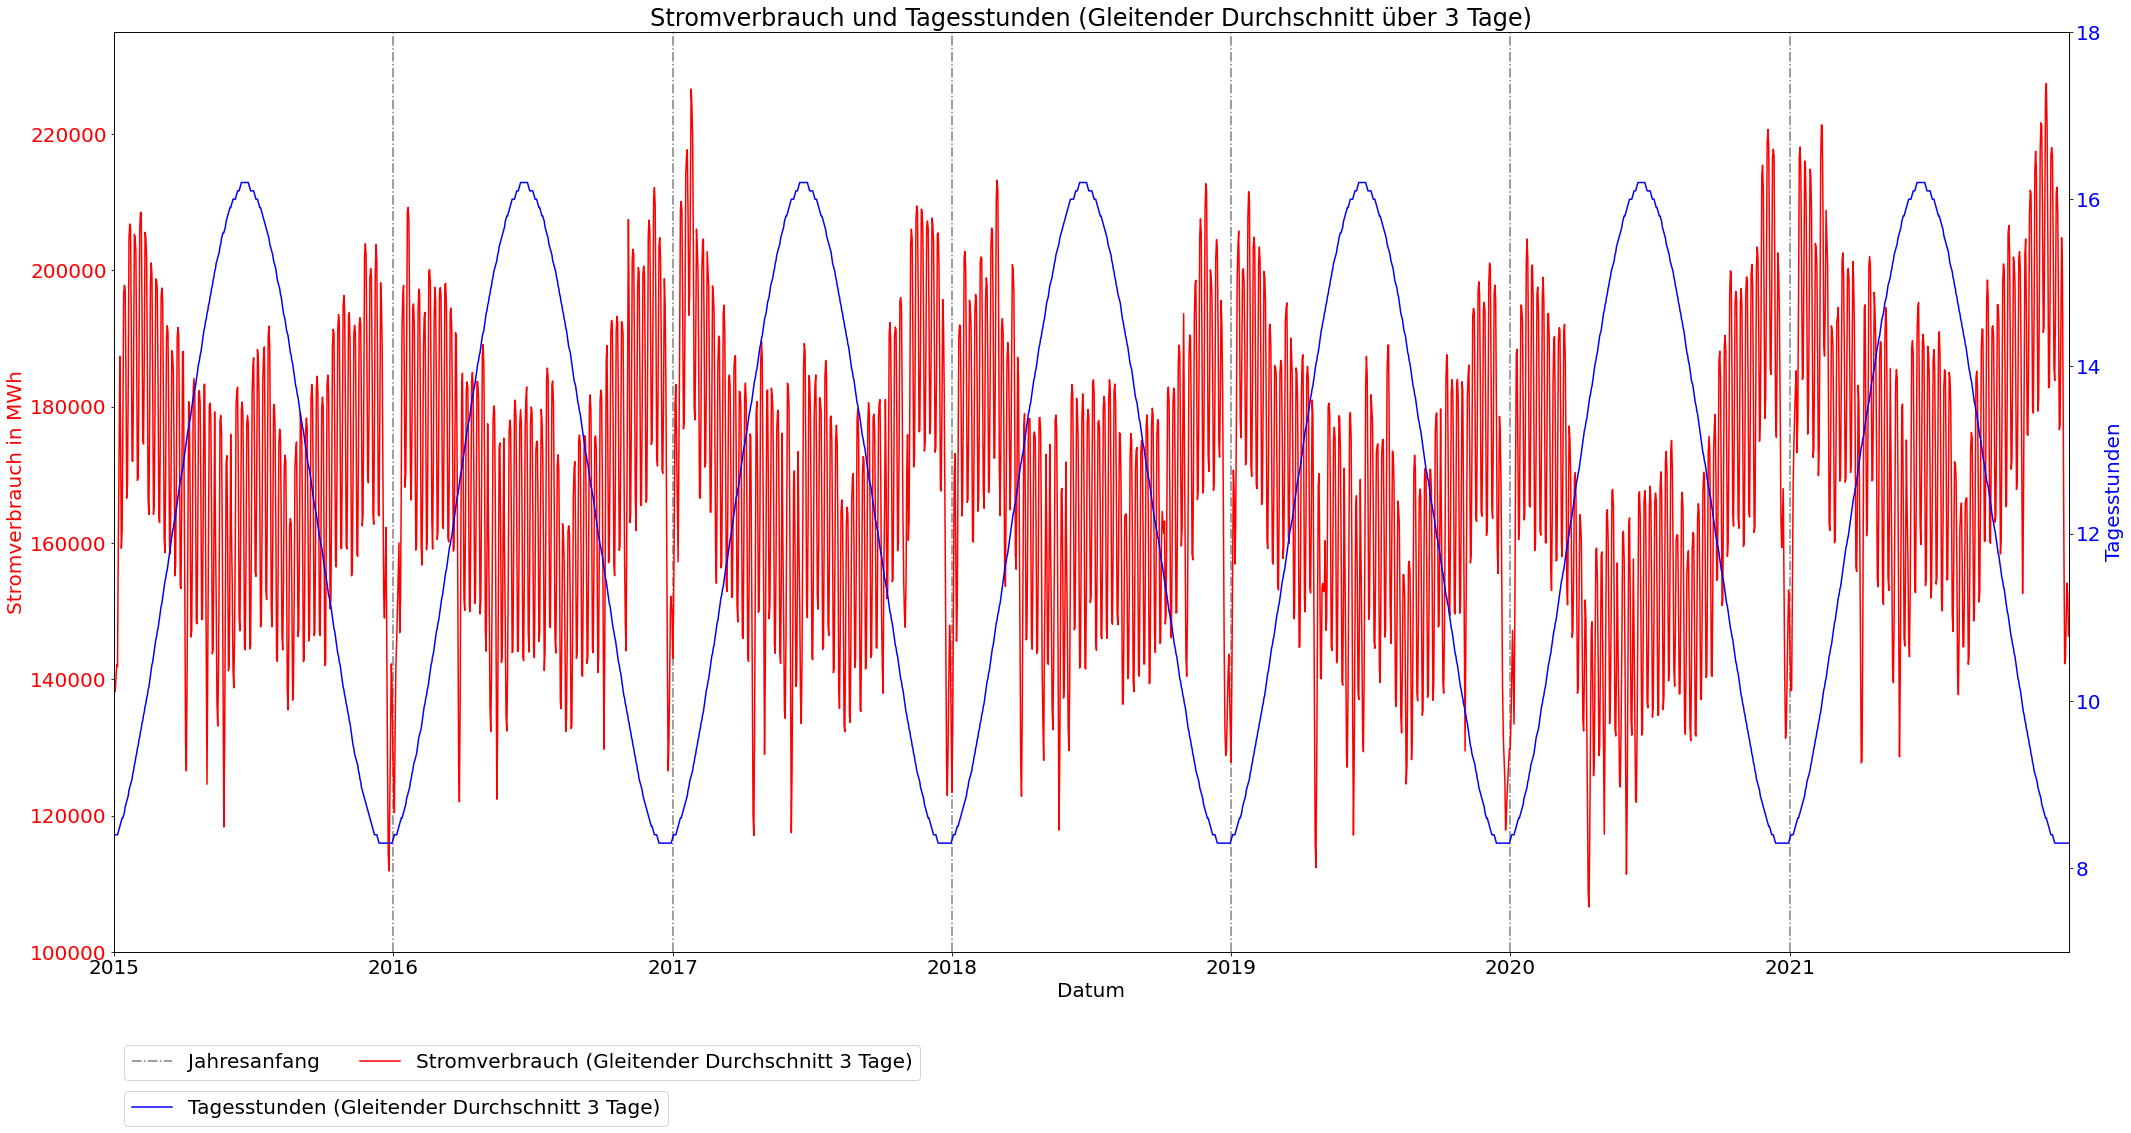

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.415
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.421
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.288





 Gleitender Durchschnitt über 7  Tage----------------------------------------------------------------------------------------------------------------------------------------------




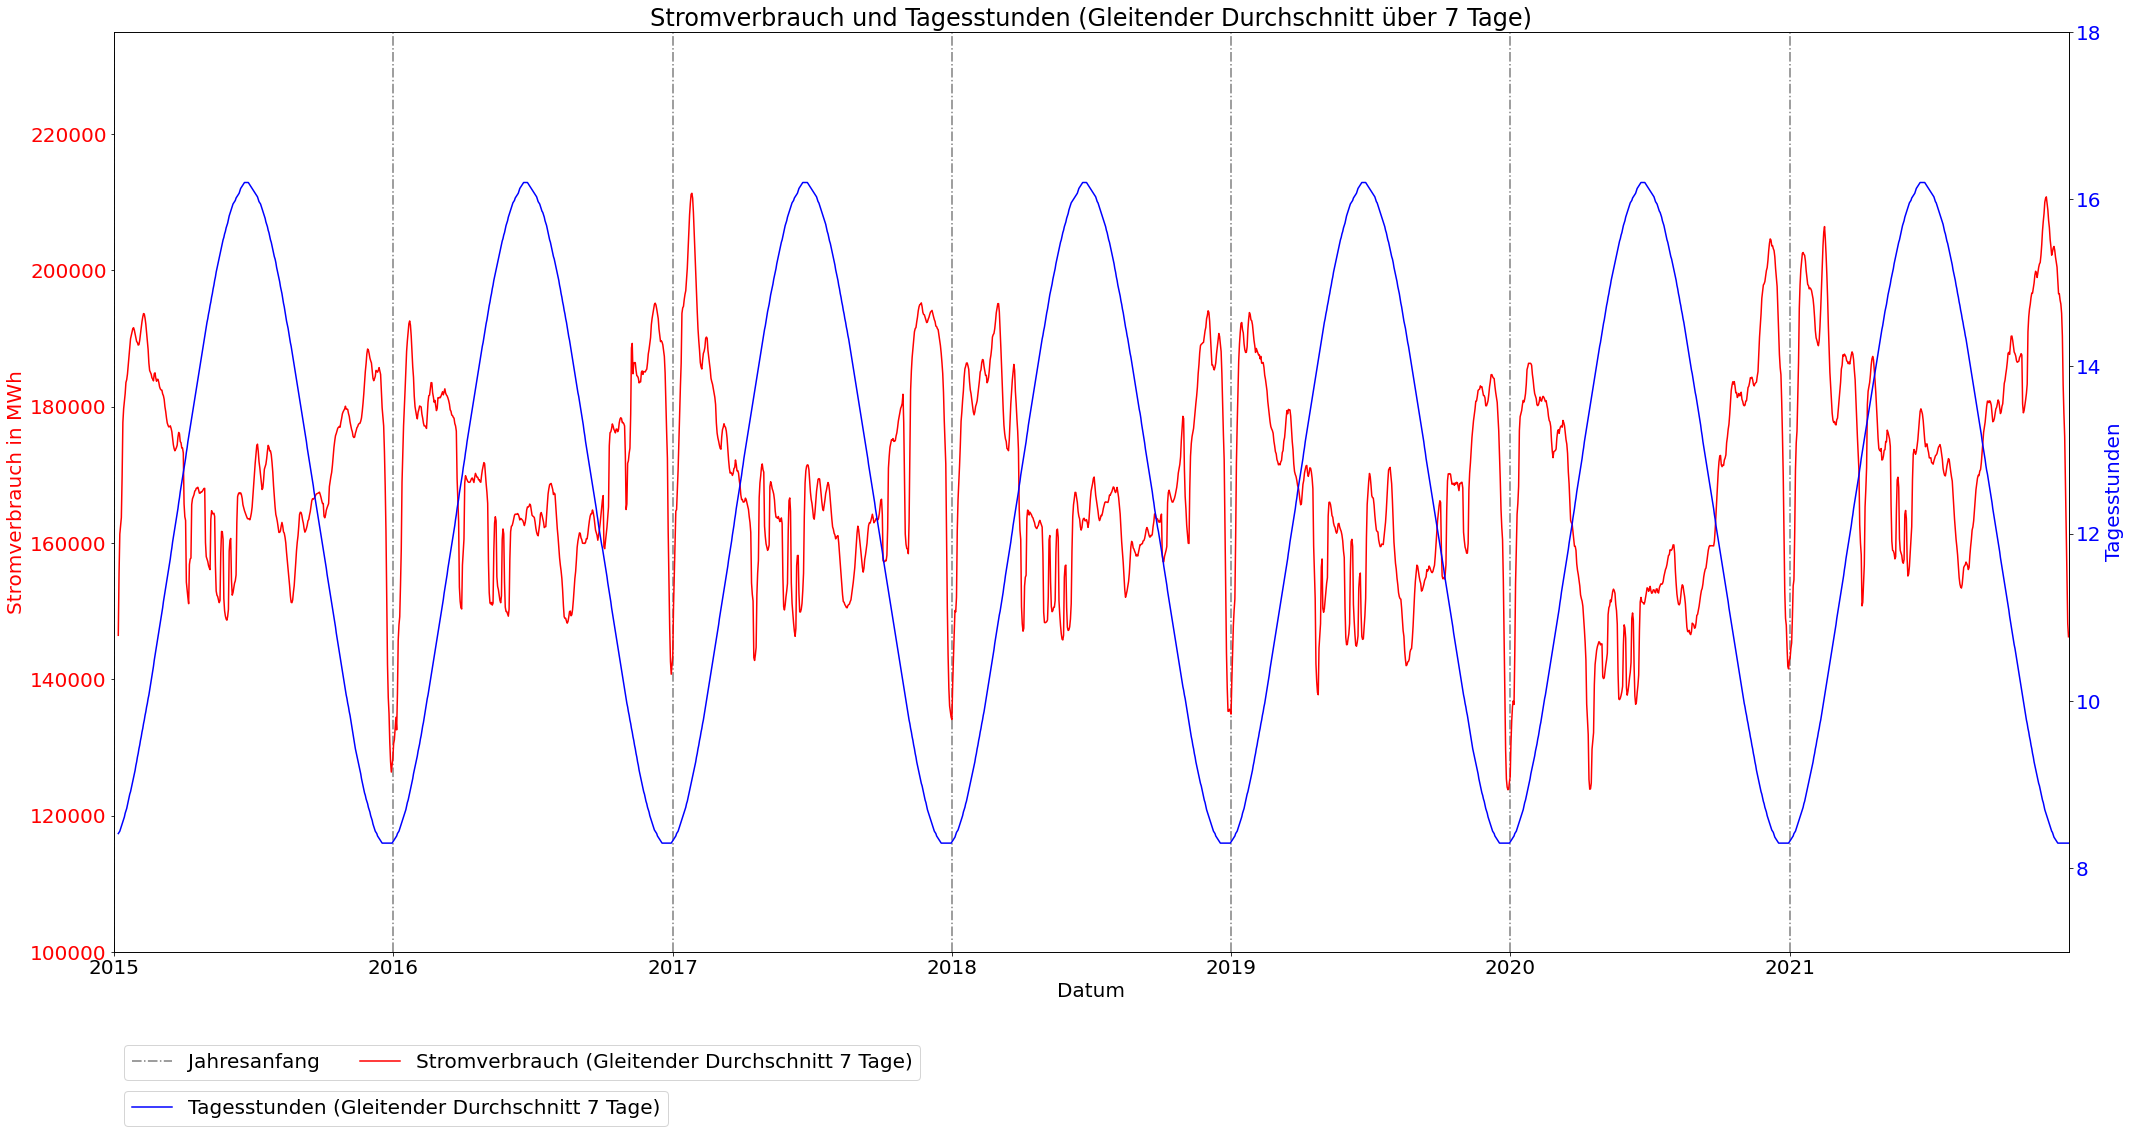

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.576
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.612
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.445





 Gleitender Durchschnitt über 14  Tage----------------------------------------------------------------------------------------------------------------------------------------------




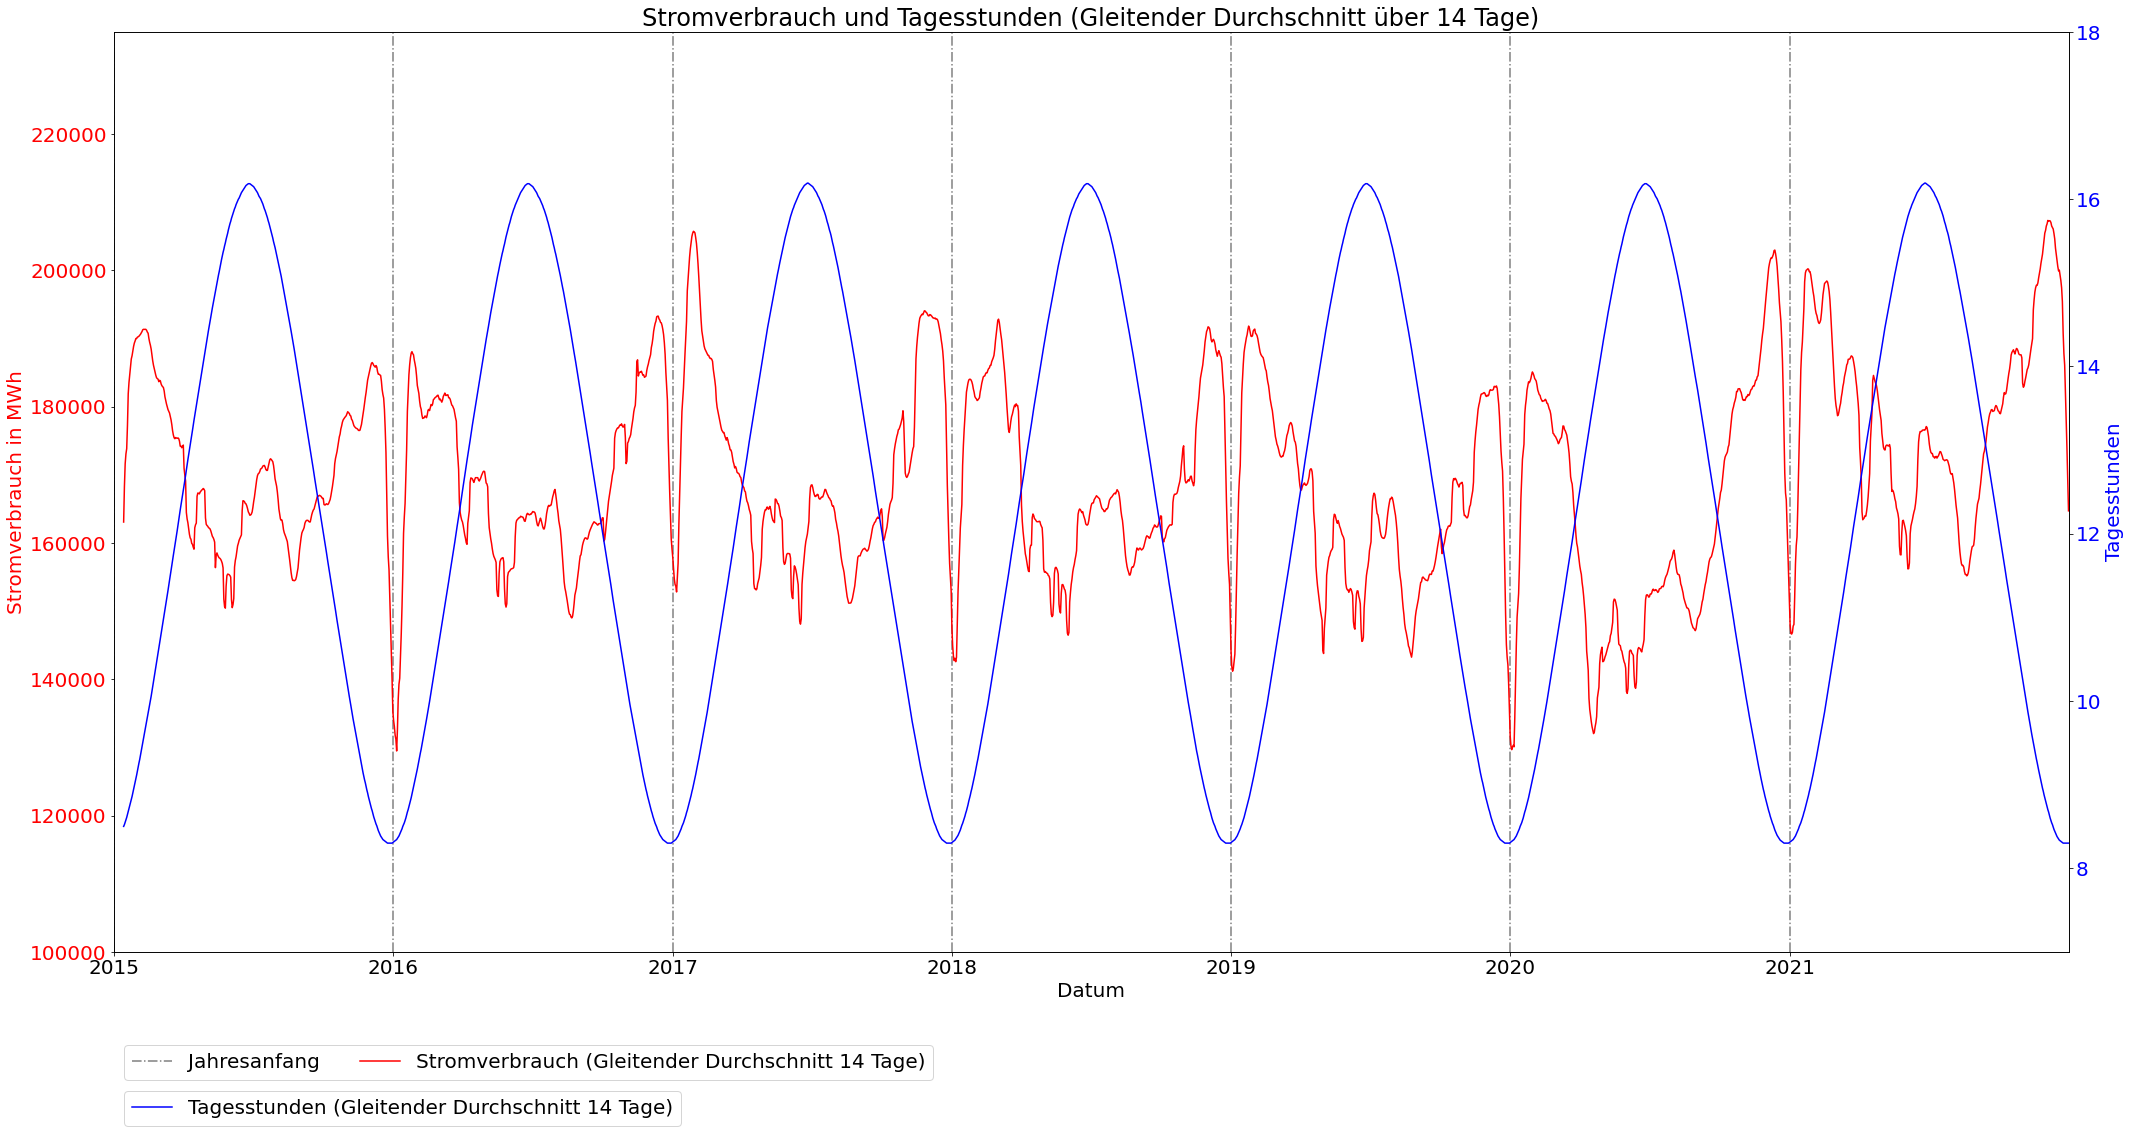

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.619
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.633
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.463





 Gleitender Durchschnitt über 28  Tage----------------------------------------------------------------------------------------------------------------------------------------------




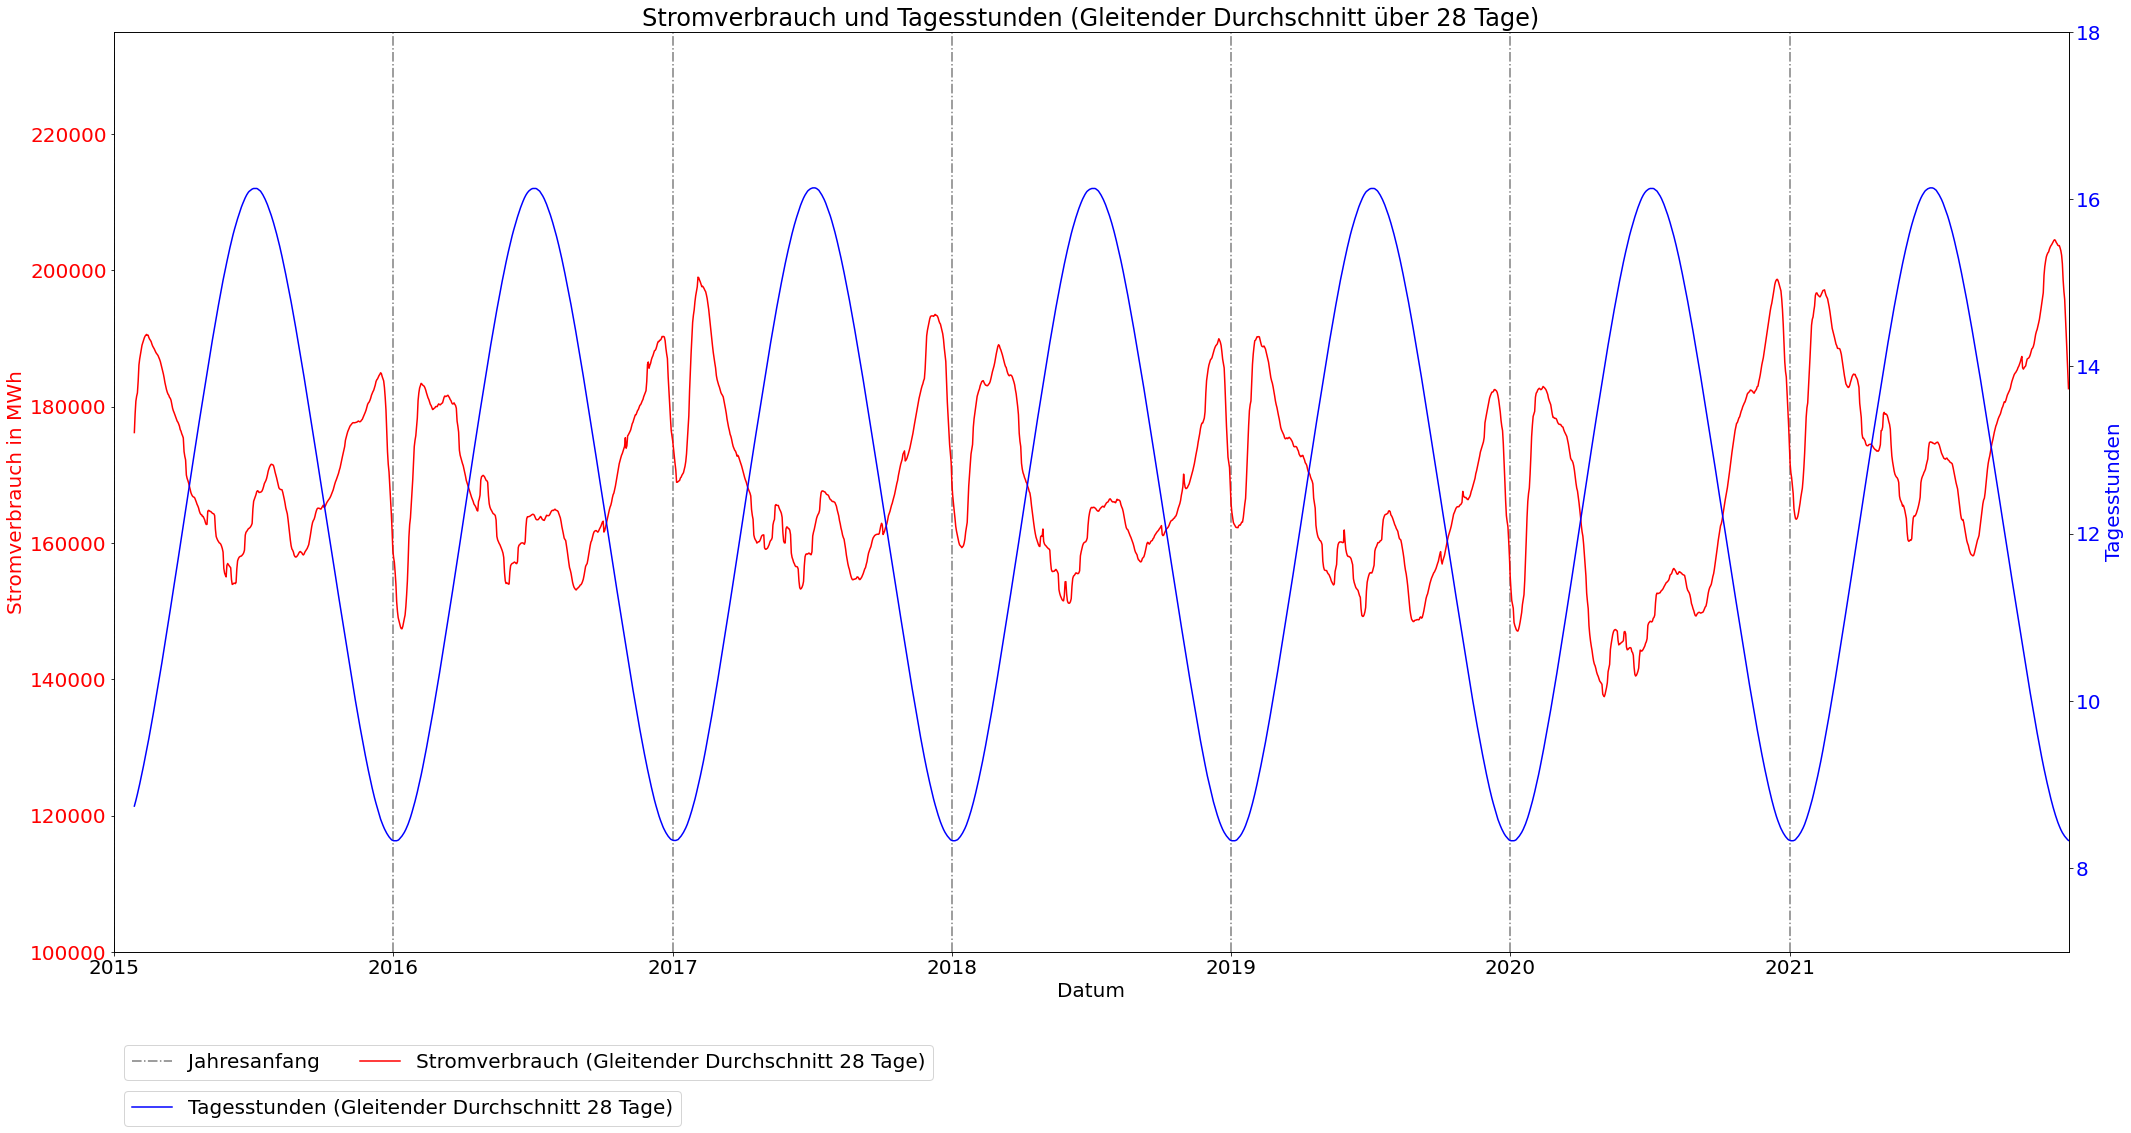

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.672
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.677
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.487





In [7]:
#Durchlaufen verschiedener gleitender Durchschnitte
for window in [3, 7, 14, 28]:

    print("\n\n", "Gleitender Durchschnitt über", window," Tage----------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    fig, ax1 = plt.subplots()

    functions.draw_years(df)

    ax1.set_title("Stromverbrauch und Tagesstunden (Gleitender Durchschnitt über " + str(window) + " Tage)")
    
    #Gleitenden Durchschnitt des Verbrauchs plotten
    ax1.plot(df["verbrauch"].rolling(window=window).mean(), color="red", label="Stromverbrauch (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax1.set_ylabel("Stromverbrauch in MWh", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(100000,235000)
    ax1.set_xlabel("Datum")
    ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,8,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)
    
    #Gleitenden Durchschnitt der Temperatur plotten
    ax2 = ax1.twinx()
    ax2.plot(df["tagesstunden"].rolling(window=window).mean(), color="blue", label="Tagesstunden (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax2.set_ylabel("Tagesstunden", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(7, 18)
    ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

    plt.tight_layout()
    plt.show()

    #Korrelationskoeffizienten ausgeben
    functions.correlation_coefficients(df["temperatur"].rolling(window=window).mean().dropna(), df["verbrauch"].rolling(window=window).mean().dropna())
    print("\n\n")

## <font size="6">Stromverbrauch nach Tagesstunden (Scatterplot)</font>

<font size="5">Im Scatterplot ist der Stromverbrauch auf der y-Achse und die Anzahl an Tagesstunden auf der x-Achse abgebildet. Die Tage sind nach Arbeitstagen (rot) und arbeitsfreien Tagen (blau) getrennt. Per Regression wird versucht, einen linearen Zusammenhang zwischen den beiden Merkmalen zu ermitteln. Hier zeigt sich, dass der Stromverbrauch an längeren Tagen zu sinken scheint. Es besteht allerdings weiterhin die Möglichkeit einer jahreszeit-bedingten Scheinkorrelation.</font>

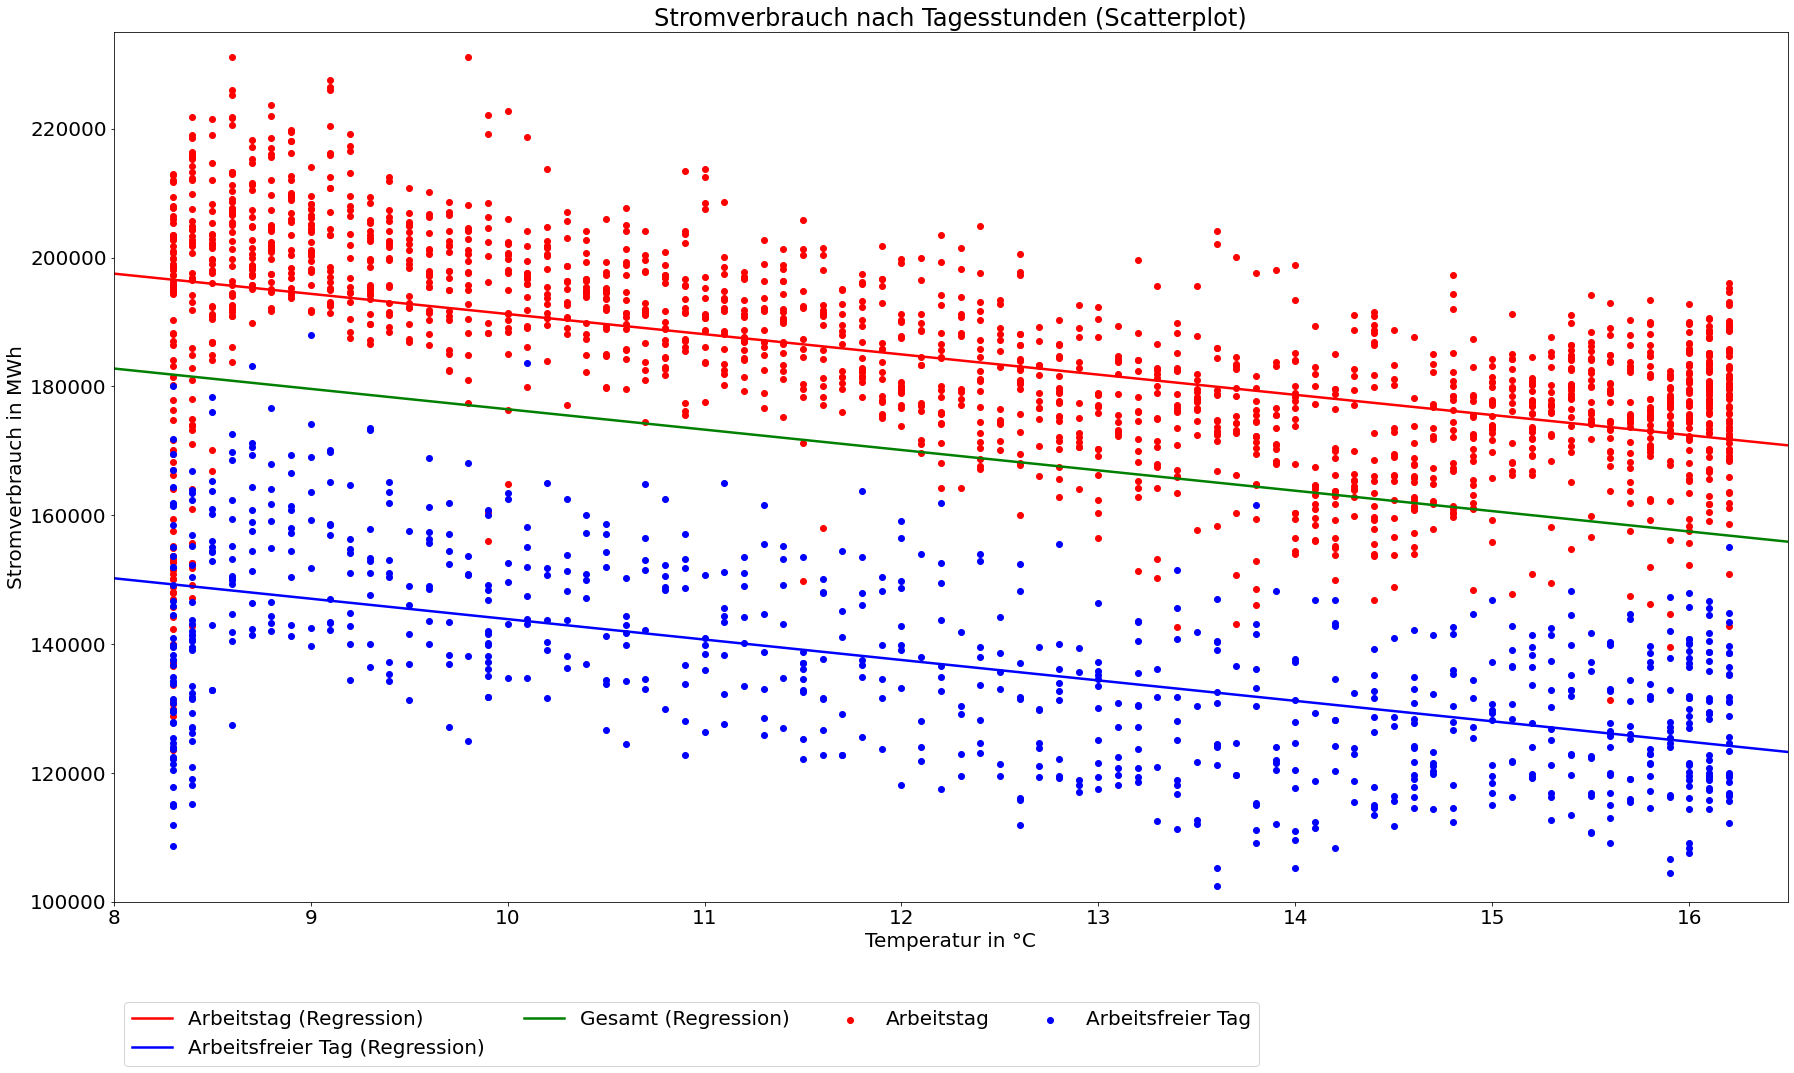

Arbeitstage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.554
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.635
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.462


Arbeitsfreie Tage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.558
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.55
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.38


In [8]:
x = range(8, 18, 1)

#Tagesstunden und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag["tagesstunden"], df_arbeitstag["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag["tagesstunden"], df_arbeitstag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Tagesstunden und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag["tagesstunden"], df_arbeitsfreiertag["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag["tagesstunden"], df_arbeitsfreiertag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["tagesstunden"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Stromverbrauch nach Tagesstunden (Scatterplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Temperatur in °C")
plt.xlim(8, 16.5)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag["temperatur"], df_arbeitstag["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag["temperatur"], df_arbeitsfreiertag["verbrauch"])

## <font size="6">Stromverbrauch nach Tagesstunden (Boxplot)</font><a class="anchor" id="2-03b-stromverbrauchnachtagesstunden"></a>

<font size="5">Die Boxplots zeigen den oben beschriebenen Zusammenhang noch einmal. Der besonders niedrige Stromverbrauch bei wenigen Tagesstunden ist auf die Weihnachtszeit beziehungsweise die damit verbundene Urlaubssaison zurückzuführen. Ende Dezember sind die Tage besonders kurz und der Stromverbrauch ist gleichzeitig sehr gering, was allerdings auf externe Effekte zurückzuführen ist. Ansonsten ist hier nochmals deutlich, dass der Stromverbrauch bei längeren Tagen fällt. Es ist allerdings auch sichtbar, dass der Stromverbrauch ab etwa 14 Tagesstunden stagniert. Dies erinnert zunächst an den Kipppunkt bei der Temperatur, allerdings steigt der Stromverbrauch ab etwa 14 Tagesstunden nicht in erkennbaren Maßen an, sondern verbleibt auf dem gleichen Level.</font>

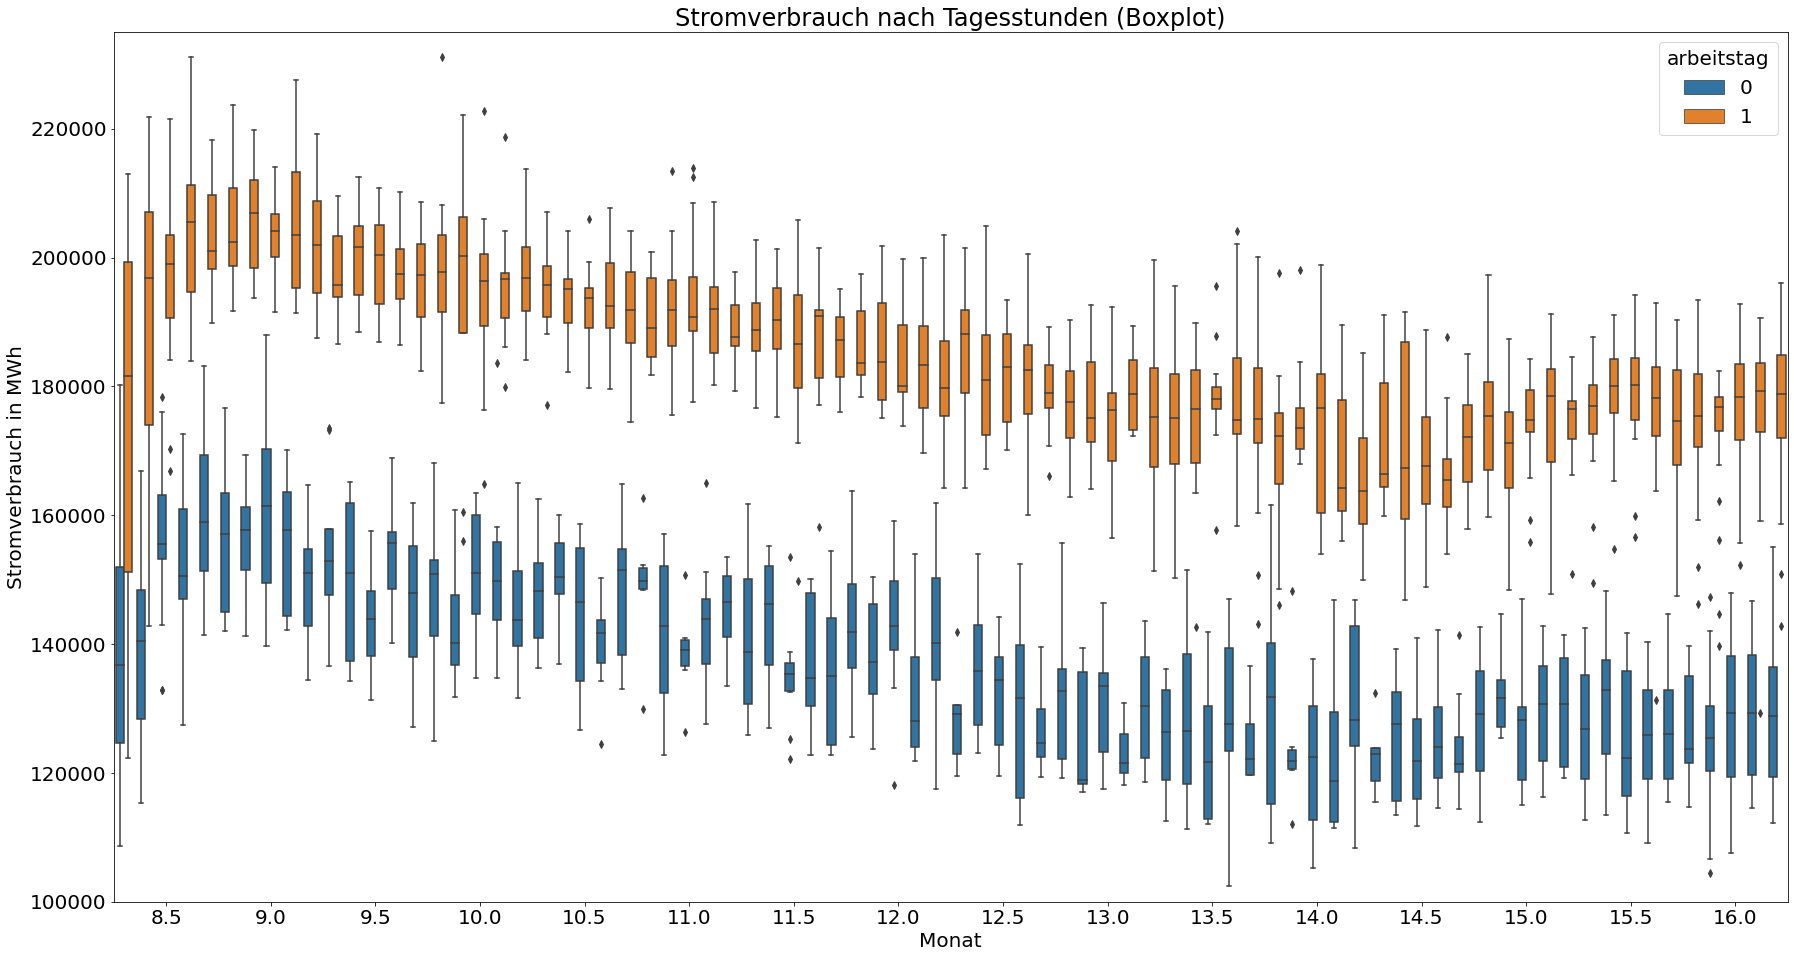

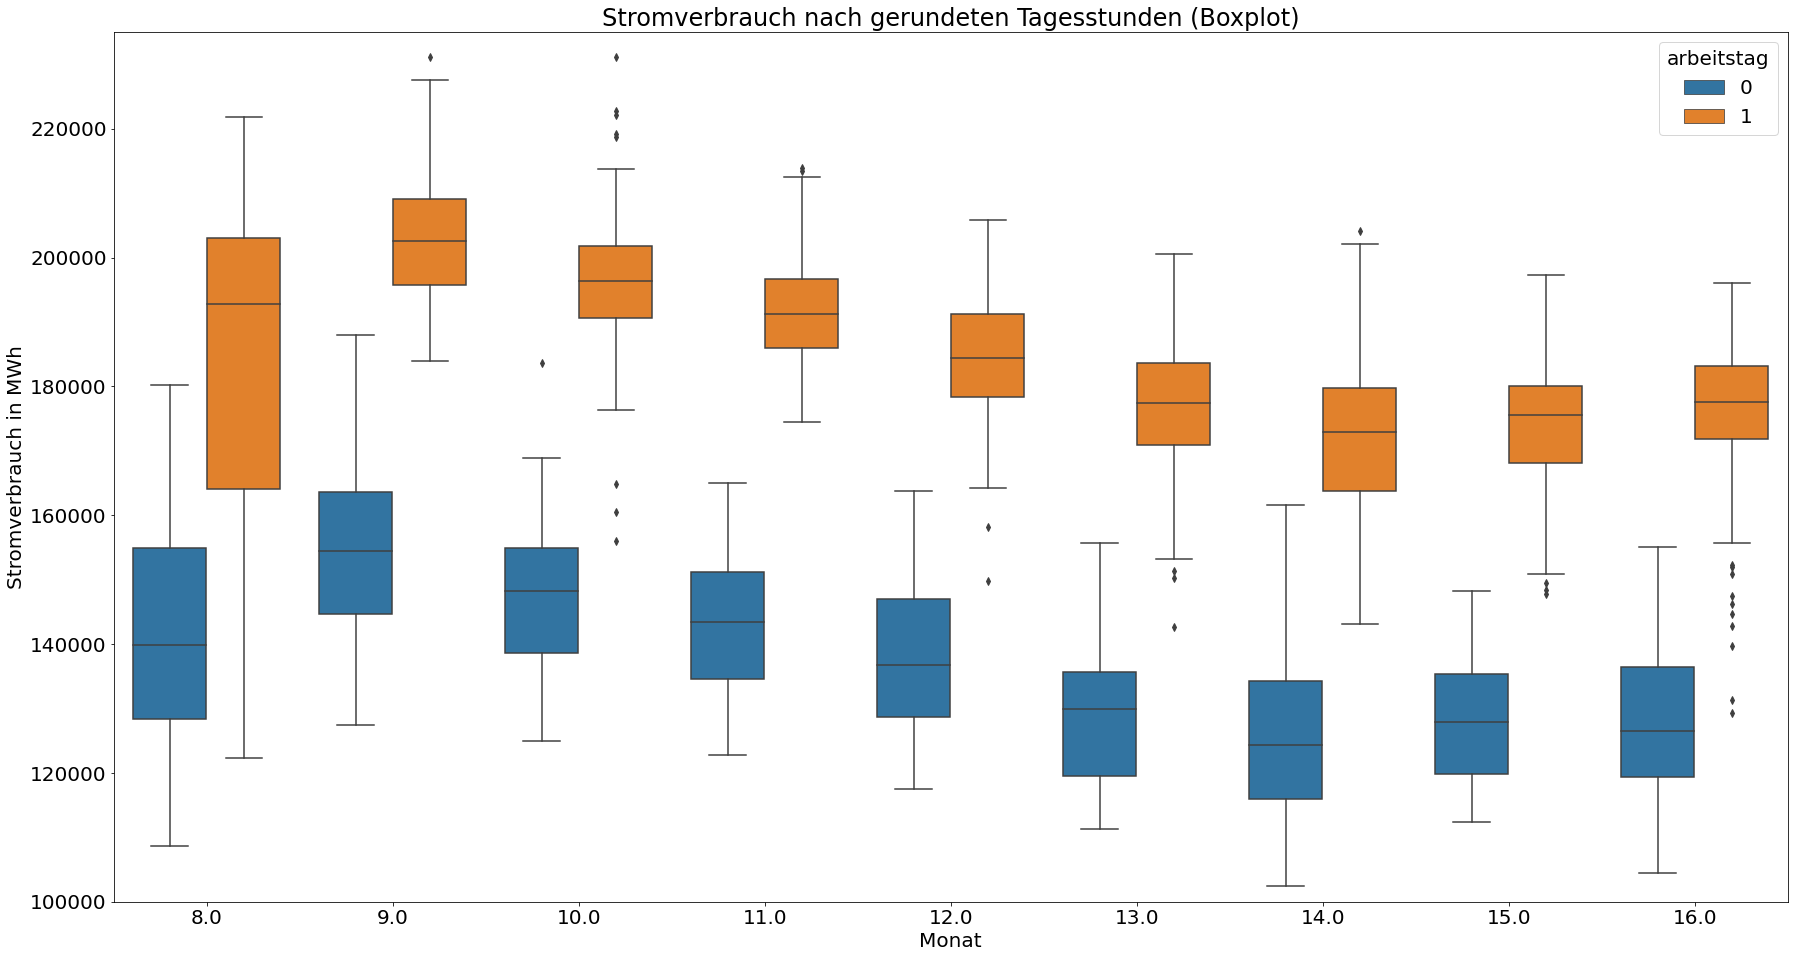

In [9]:
#Boxplot der Tagesstunden
sns.boxplot(data=df, x="tagesstunden", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach Tagesstunden (Boxplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Monat")
plt.xticks(np.arange(2, 80, 5))

plt.show()

#Boxplot der gerundeten Tagesstunden
sns.boxplot(data=df, x="tagesstunden_gerundet", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach gerundeten Tagesstunden (Boxplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Monat")

plt.show()

## <font size="6">Tagesstunden und Temperatur</font><a class="anchor" id="2-03b-tagesstundenundtemperatur"></a>

<font size="5">Wie bereits erwähnt liegt die Vermutung nahe, dass der Stromverbrauch von der Temperatur beeinflusst wird und die oben sichtbaren Zusammenhänge zwischen Stromverbrauch und Tagesstunden lediglich Scheinkorrelationen sind. Daher muss die Anzahl an Tagesstunden im Zusammenhang mit der Temperatur betrachtet werden. Im Diagramm ist erkennbar, dass die Temperatur und Anzahl der Tagesstunden (aufgrund meteorologischer Begebenheiten) ein sehr ähnlichen jährlichen Saisonalität folgen. Die Minima der beiden Merkmale liegen etwa zeitgleich im Dezember. Allerdings erreicht die Temperatur ihr Maximum etwa einen Monat später als die Tagesstunden.</font>

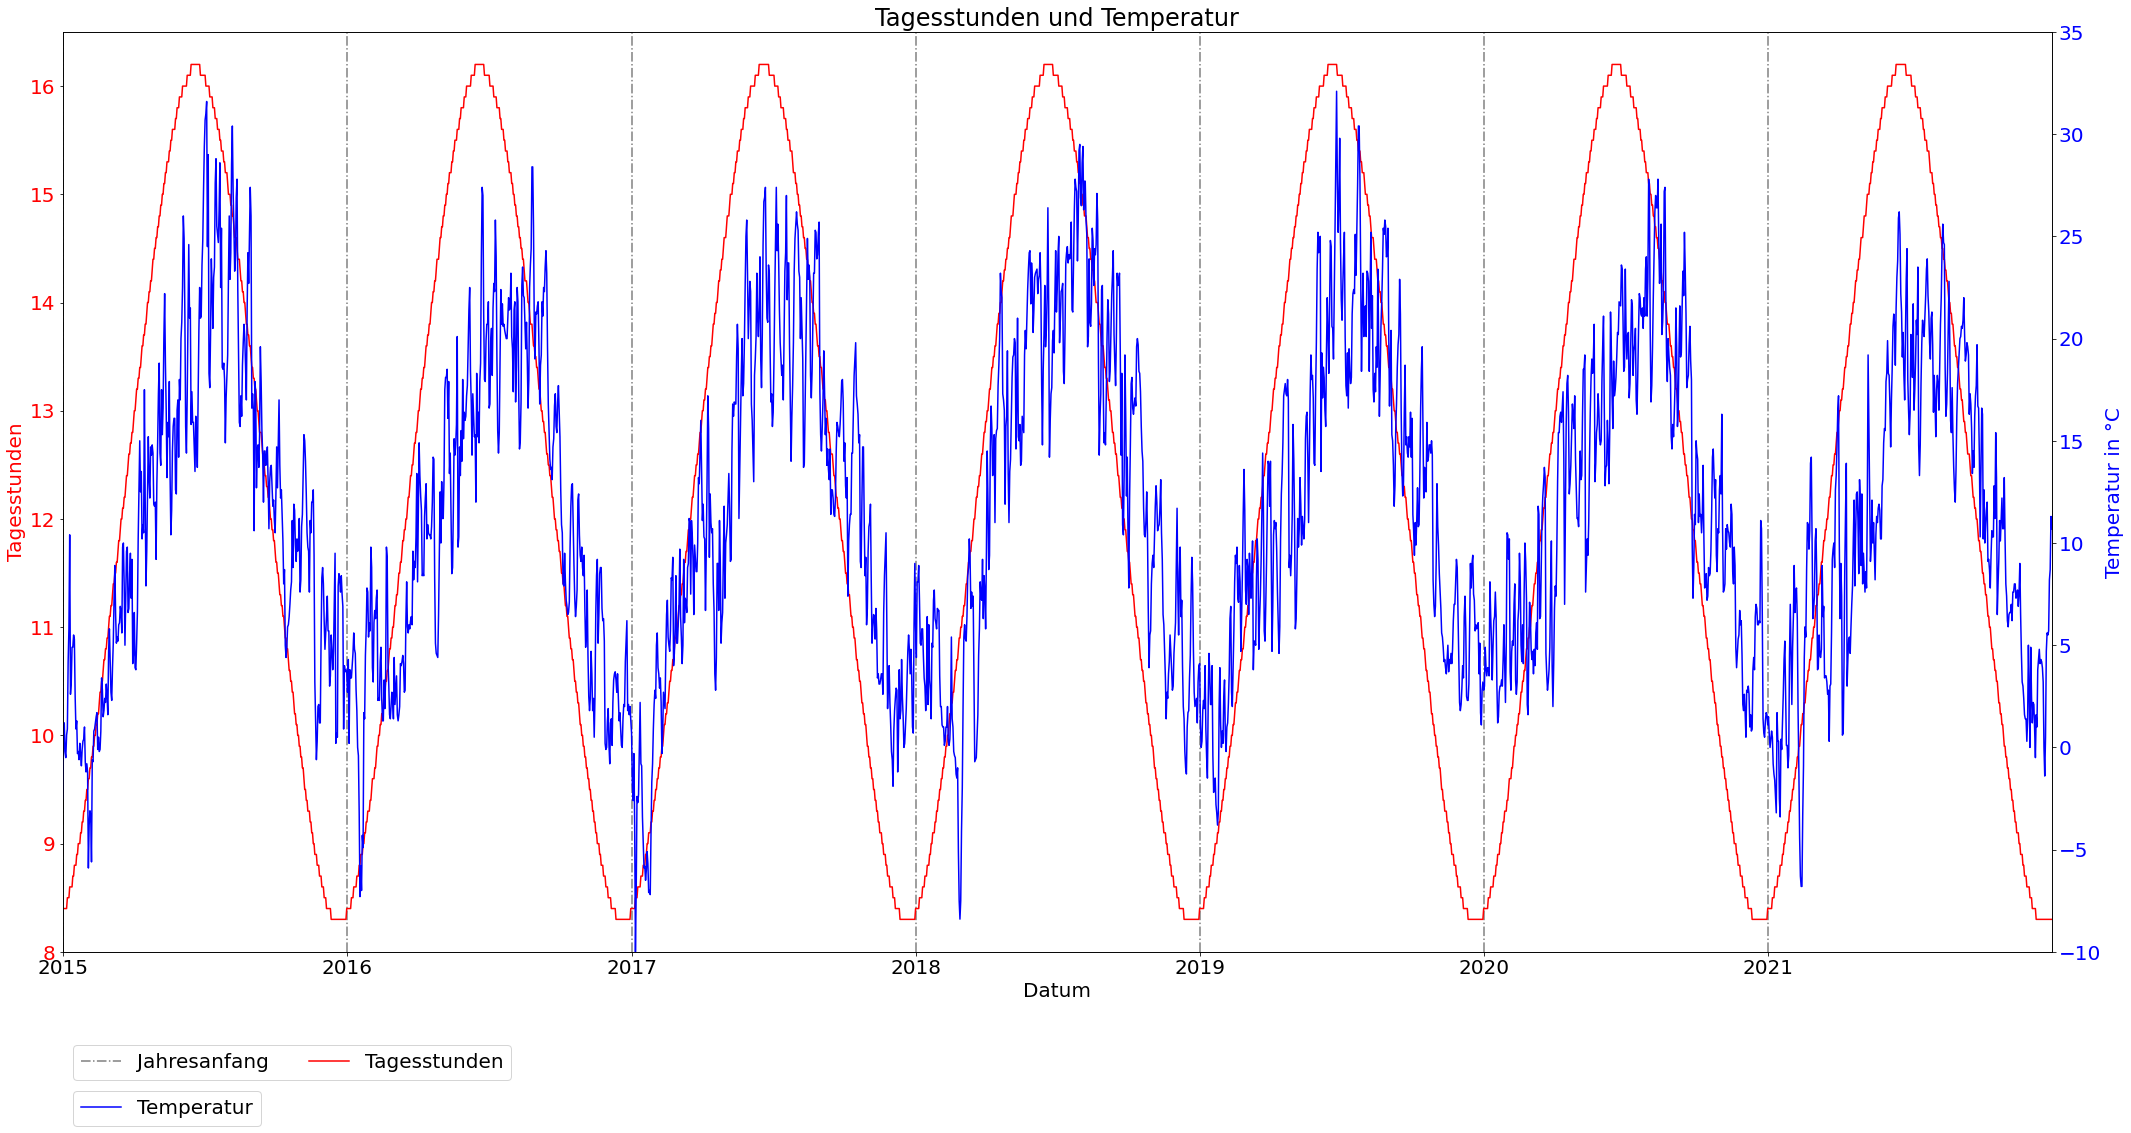

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.788
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.794
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.579





In [10]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Tagesstunden und Temperatur")

#Verbrauch plotten
ax1.plot(df["tagesstunden"], color="red", label="Tagesstunden")
#Achsen und Layout
ax1.set_ylabel("Tagesstunden", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(8, 16.5)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

#Tagesdurchschnittstemperatur plotten
ax2 = ax1.twinx()
ax2.plot(df["temperatur"], color="blue", label="Temperatur")
#Achsen und Layout
ax2.set_ylabel("Temperatur in °C", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(-10, 35)
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["tagesstunden"], df["temperatur"])
print("\n\n")

## <font size="6">Stromverbrauch nach Tagesstunden und Temperatur (Scatterplot)</font><a class="anchor" id="2-03b-scatterplot"></a>

<font size="5">Im Scatterplot sind die Temperatur auf der x-Achse und die Tagesstunden auf der y-Achse abgebildet. Gelbe Punkte repräsentieren Tage mit hohem, grüne Punkte mit mittlerem und blaue/lilane Punkte mit niedrigem Stromverbrauch. Viele Punkte mit gleicher Temperatur lassen sich anhand der y-Achse durch die Tageslänge im Stromverbrauch unterscheiden. Betrachtet man beispielsweise Tage mit etwa 10°C so erkennt man, dass die kurzen Tage im unteren Bereich tatsächlich häufig einen höheren Stromverbrauch aufweisen als die längeren Tage im oberen Bereich. Dies lässt sich sowohl bei Arbeits- wie auch bei arbeitsfreien Tagen erkennen. Es kann also davon ausgegangen werden, dass der Stromverbrauch zwar hauptsächlich durch die Temperatur, aber auch leicht durch die Tagesstunden beeinflusst wird.</font>

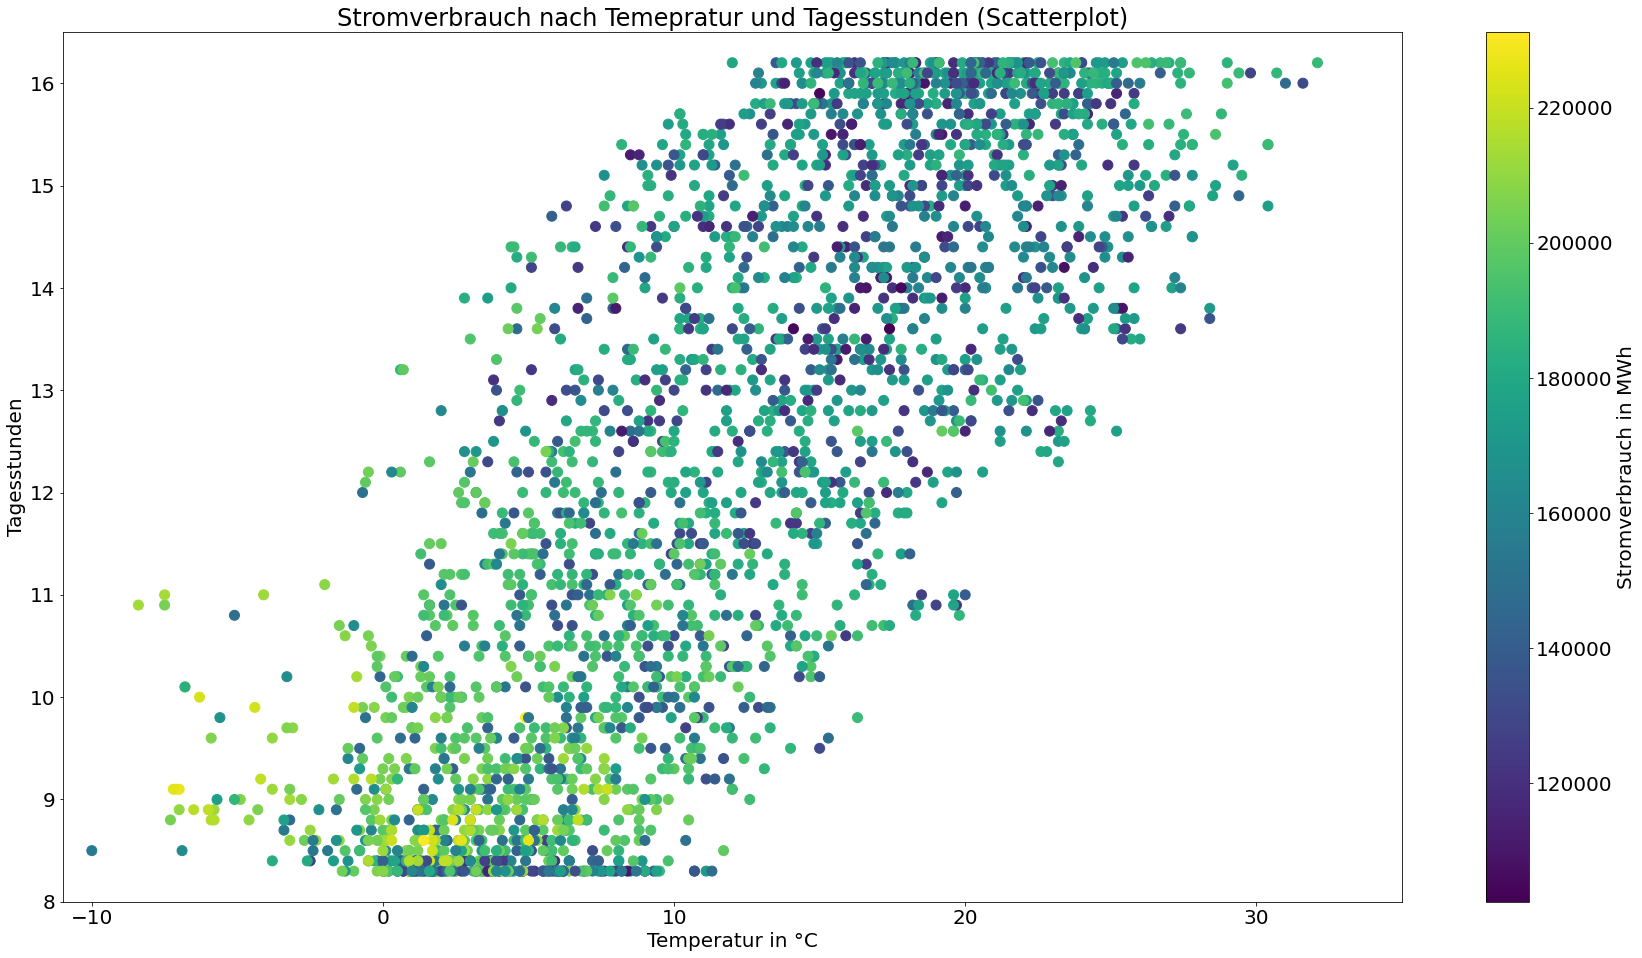

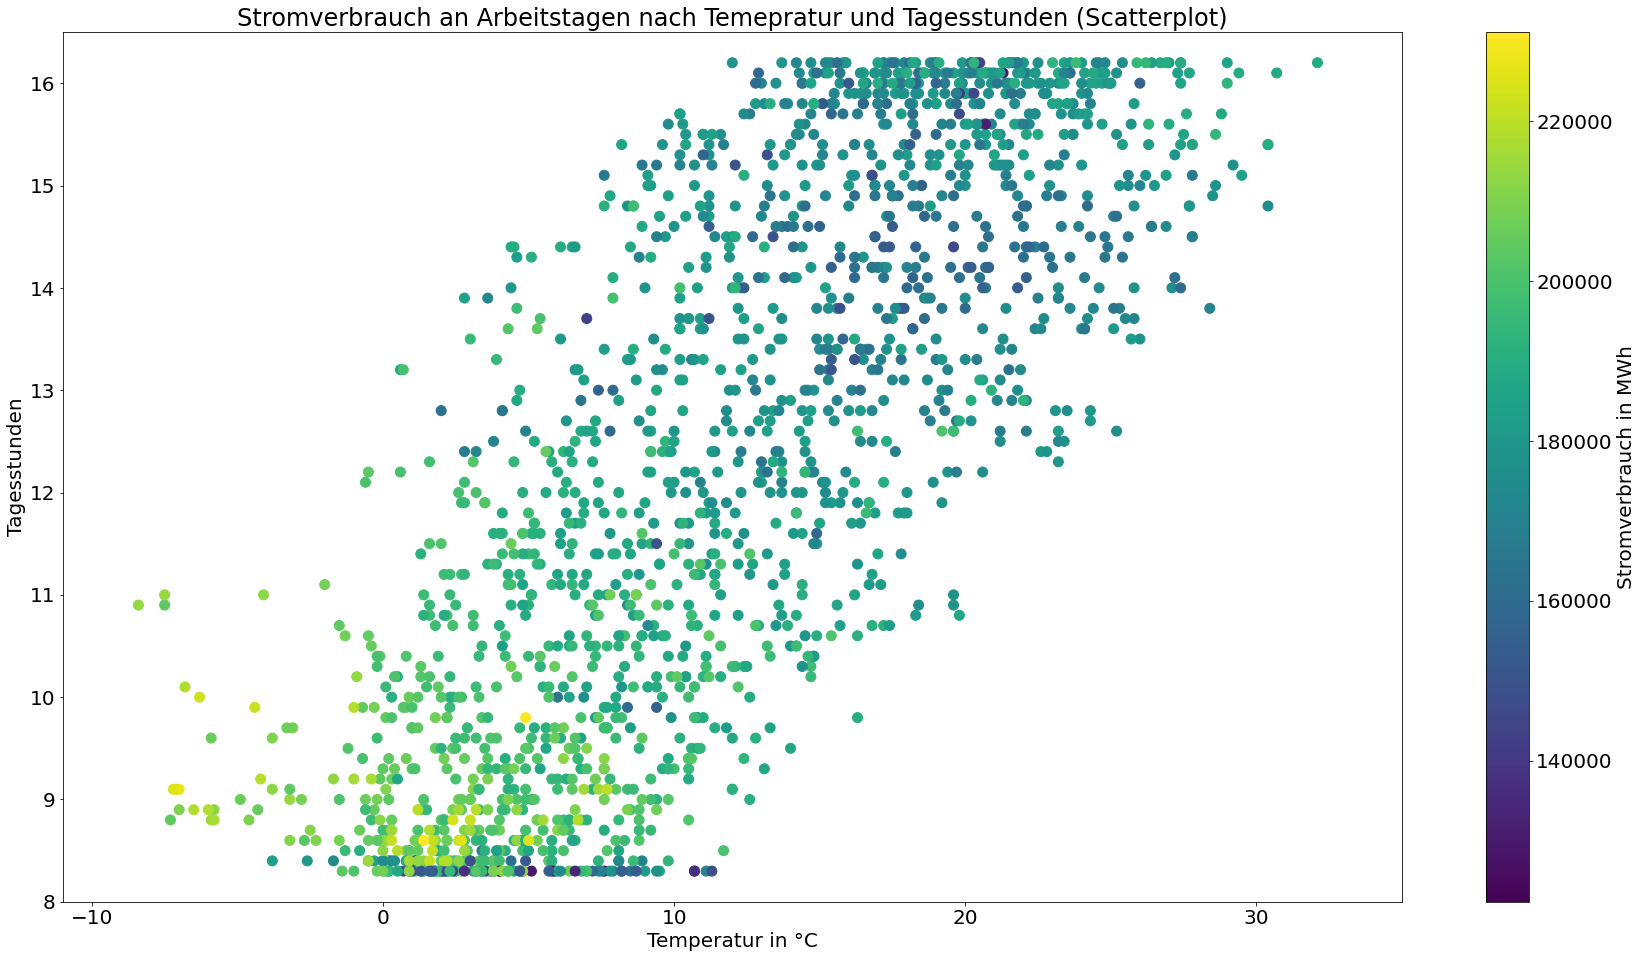

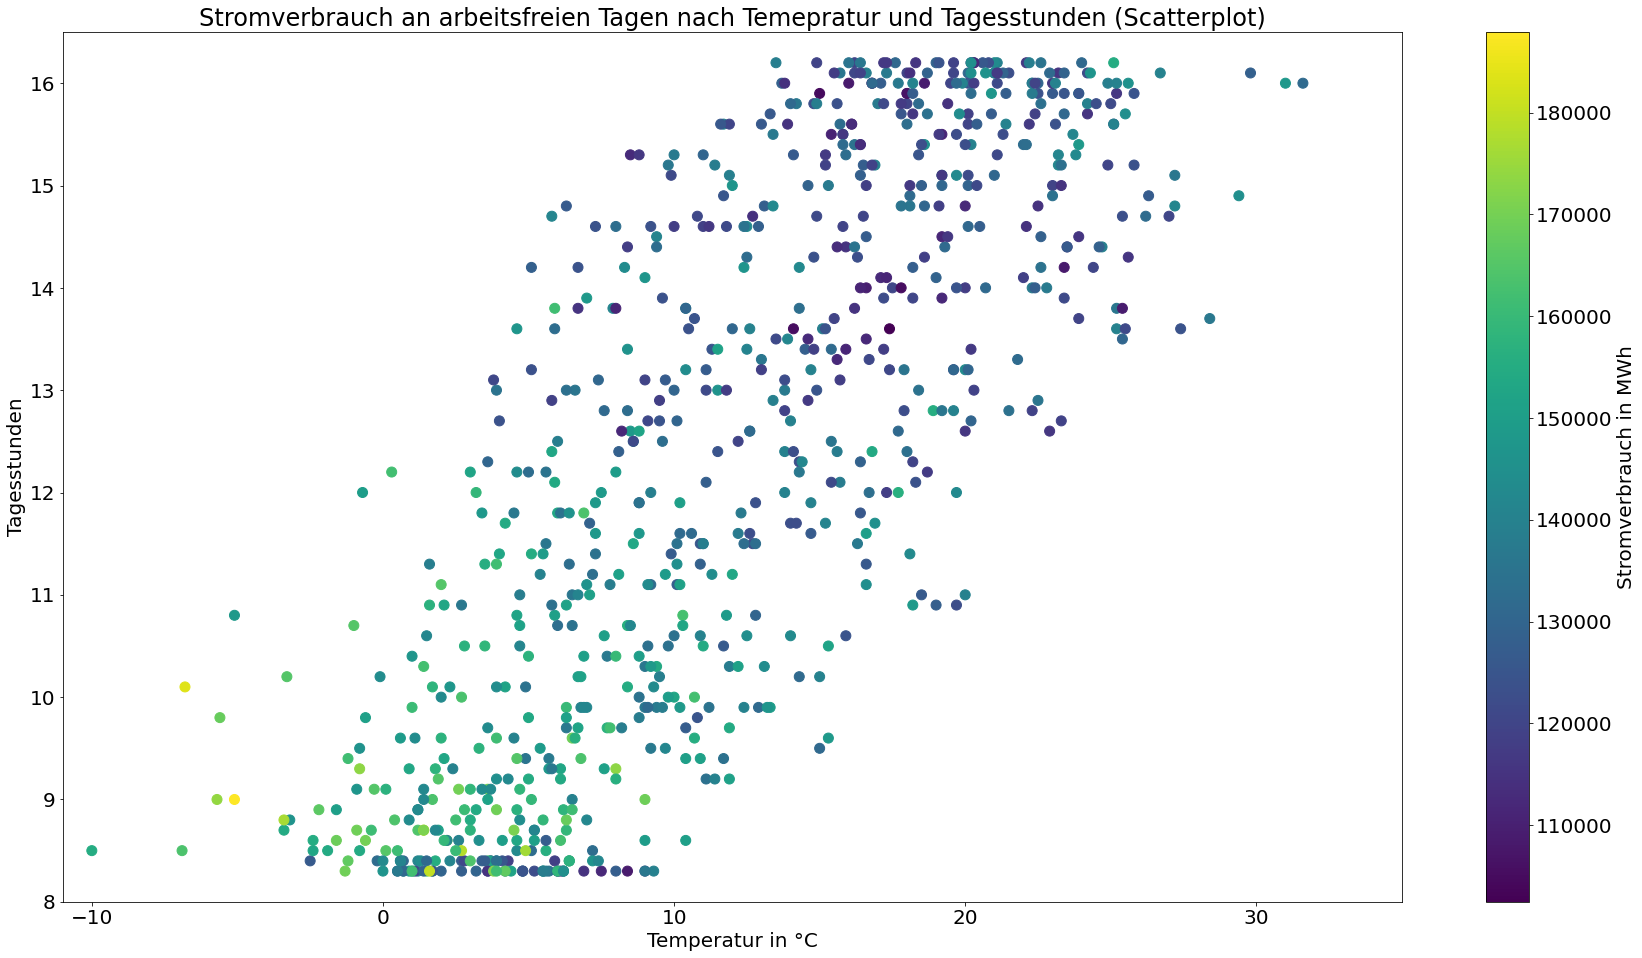

In [11]:
fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Tagesstunden und Verbrauch an allen Tagen
scat = ax.scatter(df["temperatur"], df["tagesstunden"], c=df["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Temepratur und Tagesstunden (Scatterplot)")
ax.set_ylabel("Tagesstunden")
ax.set_ylim(8, 16.5)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Tagesstunden und Verbrauch an Arbeitstagen
scat = ax.scatter(df_arbeitstag["temperatur"], df_arbeitstag["tagesstunden"], c=df_arbeitstag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch an Arbeitstagen nach Temepratur und Tagesstunden (Scatterplot)")
ax.set_ylabel("Tagesstunden")
ax.set_ylim(8, 16.5)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Tagesstunden und Verbrauch an arbeitsfreien Tagen
scat = ax.scatter(df_arbeitsfreiertag["temperatur"], df_arbeitsfreiertag["tagesstunden"], c=df_arbeitsfreiertag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch an arbeitsfreien Tagen nach Temepratur und Tagesstunden (Scatterplot)")
ax.set_ylabel("Tagesstunden")
ax.set_ylim(8, 16.5)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

# <font size="7">Regressionsanalyse</font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Tagesstunden</font>

<font size="5">Die Regression auf die Tagesstunden zeigt, dass die jährliche Bewegung des Stromverbrauchs sogar etwas besser als nur durch die Temperatur abgebildet werden kann.</font>

            verbrauch  tagesstunden
datum                              
2015-01-01   126197.0           8.4
2015-01-02   147085.0           8.4
2015-01-03   141426.0           8.4
2015-01-04   132446.0           8.4
2015-01-05   152611.0           8.4
...               ...           ...
2019-12-27   129551.0           8.3
2019-12-28   125395.0           8.3
2019-12-29   121331.0           8.3
2019-12-30   137130.0           8.3
2019-12-31   131060.0           8.3

[1826 rows x 2 columns]
       Vorhersage
R2            0.1
MAE       20201.2
MSE   601848537.2
RMSE      24532.6
                 
MAPE       13.7 %


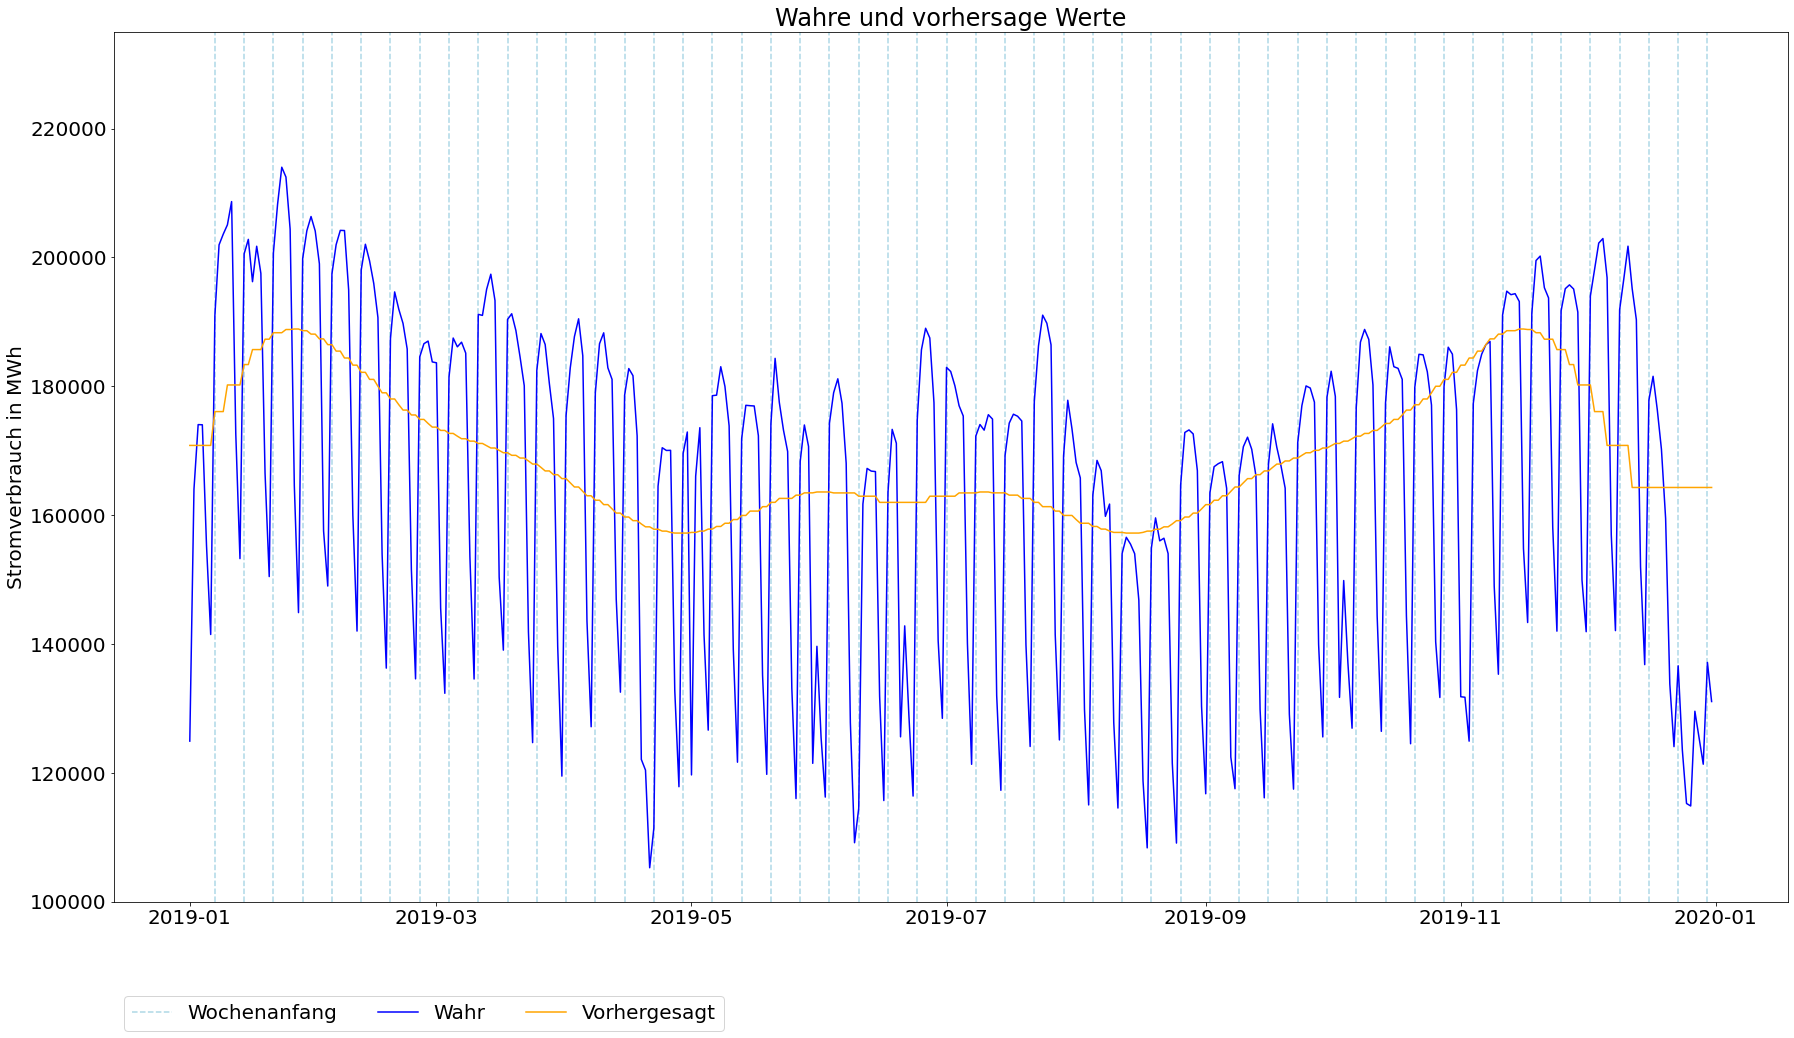

In [12]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["tagesstunden"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["tagesstunden"]].values.reshape(-1, 1))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["tagesstunden"]])
X_test = pf.transform(test[["tagesstunden"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstag und Tagesstunden</font>

<font size="5">Mittels Regression auf den Indikator für Arbeitstage und die Anzahl an Tagesstunden lässt sich der Verlauf ähnlich gut wie mit der Temperatur abbilden. Allerdings schwächelt das Regressionsmodell mit der Abbildung der wöchentlichen Saisonalität und ist stark nach oben verzerrt.</font>

            verbrauch  arbeitstag  tagesstunden
datum                                          
2015-01-01   126197.0         0.0           8.4
2015-01-02   147085.0         1.0           8.4
2015-01-03   141426.0         0.0           8.4
2015-01-04   132446.0         0.0           8.4
2015-01-05   152611.0         1.0           8.4
...               ...         ...           ...
2019-12-27   129551.0         1.0           8.3
2019-12-28   125395.0         0.0           8.3
2019-12-29   121331.0         0.0           8.3
2019-12-30   137130.0         1.0           8.3
2019-12-31   131060.0         1.0           8.3

[1826 rows x 3 columns]
       Vorhersage
R2            0.8
MAE        8654.1
MSE   133855934.6
RMSE      11569.6
                 
MAPE        5.7 %


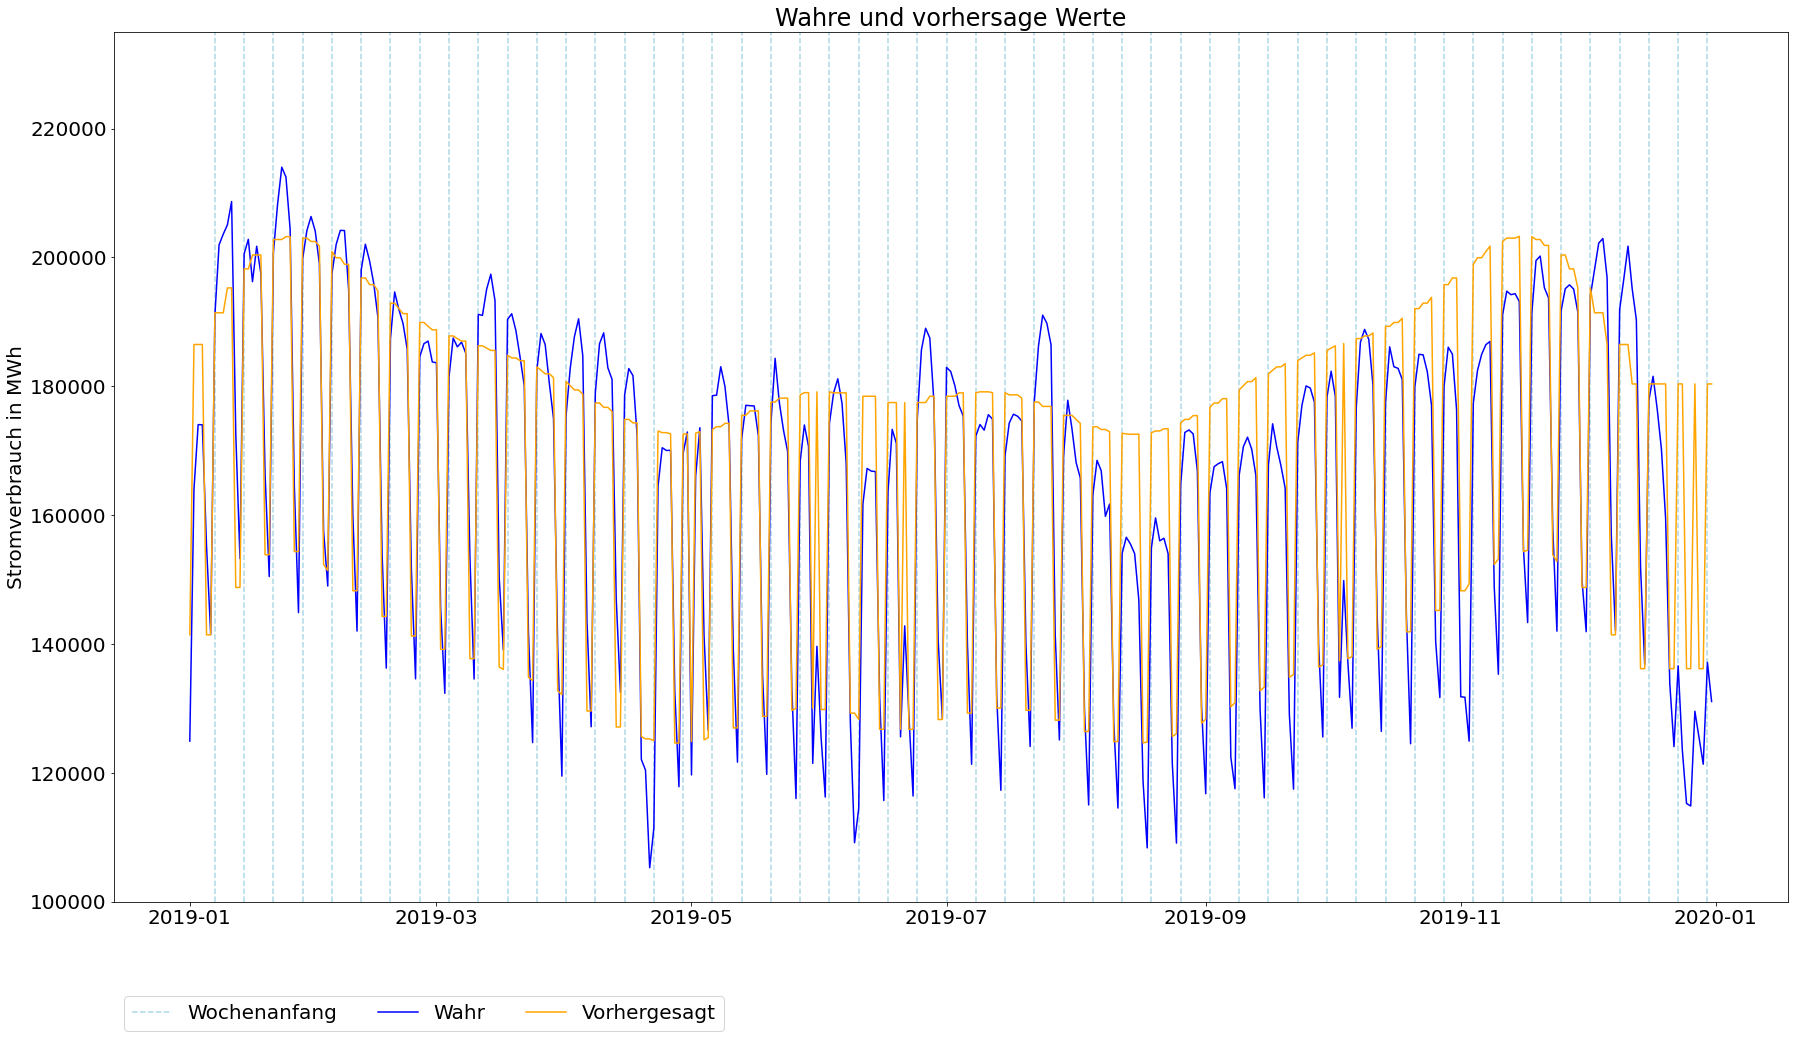

In [13]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["tagesstunden"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "tagesstunden"]].values.reshape(-2, 2))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "tagesstunden"]])
X_test = pf.transform(test[["arbeitstag", "tagesstunden"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstagen, Temperatur und Tagesstunden</font><a class="anchor" id="2-03b-regressionalles"></a>

<font size="5">Wenn zusätzlich zum Indikator für Arbeitstage und der Temperatur noch die Tagesstunden in das Modell einbezogen werden, dann ergibt sich zunächst kein wirklicher zusätzlicher Informationsgewinn. Das Modell kann stellenweise Verläufe besser oder schlechter erfassen. Insgesamt scheinen die Tagesstunden das Modell jedoch eher zu verschlechtern, was allerdings auch zufällig sein kann.</font>

            verbrauch  arbeitstag  temperatur  tagesstunden
datum                                                      
2015-01-01   126197.0         0.0        -2.5           8.4
2015-01-02   147085.0         1.0        -0.0           8.4
2015-01-03   141426.0         0.0         1.2           8.4
2015-01-04   132446.0         0.0        -0.2           8.4
2015-01-05   152611.0         1.0        -0.5           8.4
...               ...         ...         ...           ...
2019-12-27   129551.0         1.0         5.1           8.3
2019-12-28   125395.0         0.0         1.7           8.3
2019-12-29   121331.0         0.0         1.1           8.3
2019-12-30   137130.0         1.0         2.8           8.3
2019-12-31   131060.0         1.0         3.2           8.3

[1826 rows x 4 columns]
       Vorhersage
R2            0.7
MAE       10201.8
MSE   204229323.4
RMSE      14290.9
                 
MAPE        6.6 %


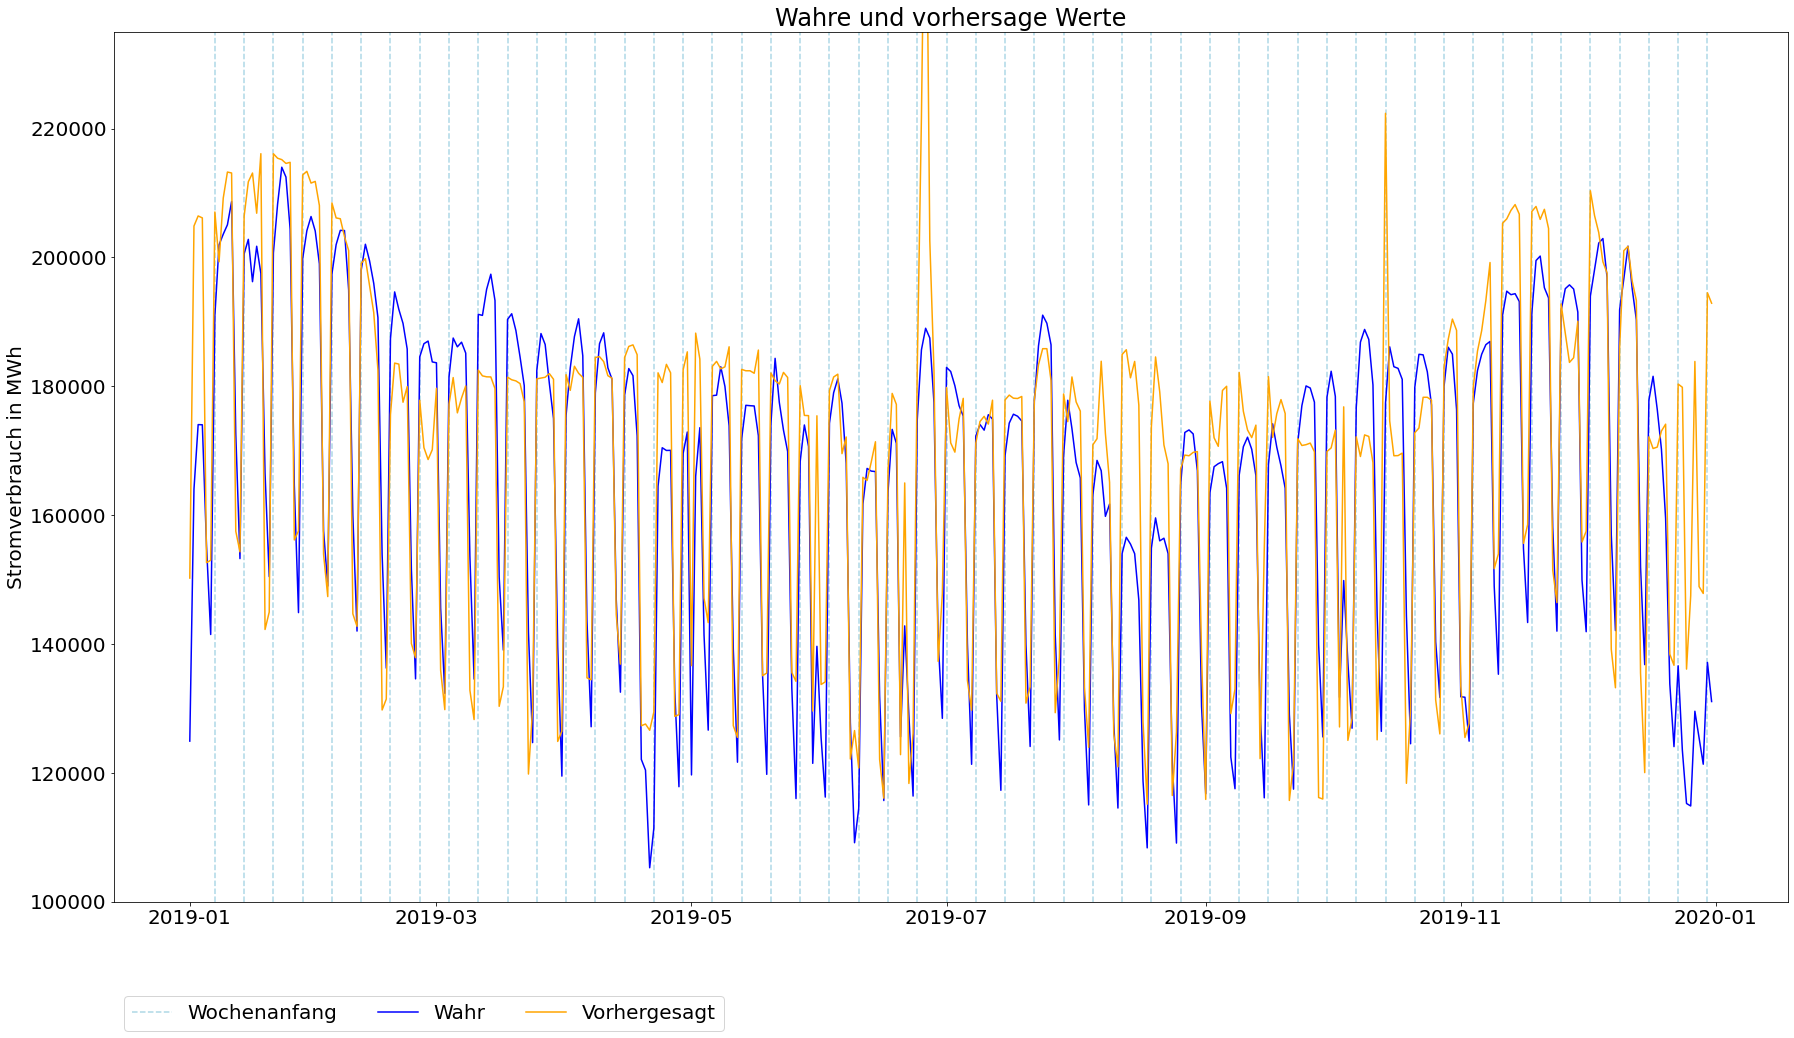

In [14]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["temperatur"], df["tagesstunden"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "temperatur", "tagesstunden"]].values.reshape(-3, 3))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "temperatur", "tagesstunden"]])
X_test = pf.transform(test[["arbeitstag", "temperatur", "tagesstunden"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

# <font size="7">Fazit</font>
<font size="5">Der Zusammenhang des Stromverbrauchs und der Anzahl an Tagesstunden ist zwar sehr viel schwächer als beispielsweise bei der Temperatur, allerdings werden die Tagesstunden trotzdem für das Modeling verwendet, da sich ein schwacher, aber dennoch nachweisbarer Zusammenhang ergibt. Bei der Modellierung ist allerdings zu prüfen, ob und inwieweit die Modelle durch die Tagesstunden verbessert werden oder ob das Merkmal gegebenenfalls entfernt werden sollte.</font>

## <font size="6">Daten speichern</font>

<font size="5">Die als relevant und aussagekräftig ermittelten oder für Analysen relevanten Daten werden in der Datei „data.csv“ zwischengespeichert.</font>

In [15]:
df = df[["verbrauch", "monat", "wochentag", "arbeitstag", "temperatur"]]
df["sonnenaufgang"] = df_["sonnenaufgang"]
df["sonnenuntergang"] = df_["sonnenuntergang"]

print(df)

df.to_csv("data.csv")

            verbrauch     monat   wochentag  arbeitstag  temperatur sonnenaufgang sonnenuntergang
datum                                                                                            
2015-01-01     126197    Januar  Donnerstag           0        -2.5      08:16 AM        04:37 PM
2015-01-02     147085    Januar     Freitag           1        -0.0      08:16 AM        04:38 PM
2015-01-03     141426    Januar     Samstag           0         1.2      08:16 AM        04:39 PM
2015-01-04     132446    Januar     Sonntag           0        -0.2      08:16 AM        04:40 PM
2015-01-05     152611    Januar      Montag           1        -0.5      08:16 AM        04:41 PM
...               ...       ...         ...         ...         ...           ...             ...
2021-12-27     153489  Dezember      Montag           1         5.7      08:16 AM        04:33 PM
2021-12-28     155182  Dezember    Dienstag           1         8.2      08:16 AM        04:34 PM
2021-12-29     15361